# Imports/Libraries 

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from scipy.stats import spearmanr
import missingno as msno

## Display parameters 

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 10, 5
warnings.filterwarnings('ignore')

# Initial EDA

In [3]:
# Read in data as pandas dataframe 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
#Display dataframe info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [6]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [7]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.drop(train[(train['1stFlrSF']>4500) & (train['SalePrice']<200000)].index, inplace=True)
train.drop(train[(train['BsmtFinSF1']>5500) & (train['SalePrice']<200000)].index, inplace=True)
train.drop(train[(train['TotalBsmtSF']>5500) & (train['SalePrice']<200000)].index, inplace=True)

train.reset_index(drop=True, inplace=True)

In [8]:
# Display dimentions of both dataframes
print(f'Train Columns = {train.shape[1]}, Rows = {train.shape[0]}')
print()
print(f'Test Columns = {test.shape[1]}, Rows = {test.shape[0]}')

Train Columns = 80, Rows = 1457

Test Columns = 79, Rows = 1459


In [9]:
# Split features and target
train_target = train['SalePrice'].reset_index(drop=True)

train_features = train.copy()
train_features = train_features.drop(['SalePrice'], axis=1)

test_features = test.copy()

In [10]:
# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 79 columns):
MSSubClass       2916 non-null int64
MSZoning         2912 non-null object
LotFrontage      2431 non-null float64
LotArea          2916 non-null int64
Street           2916 non-null object
Alley            198 non-null object
LotShape         2916 non-null object
LandContour      2916 non-null object
Utilities        2914 non-null object
LotConfig        2916 non-null object
LandSlope        2916 non-null object
Neighborhood     2916 non-null object
Condition1       2916 non-null object
Condition2       2916 non-null object
BldgType         2916 non-null object
HouseStyle       2916 non-null object
OverallQual      2916 non-null int64
OverallCond      2916 non-null int64
YearBuilt        2916 non-null int64
YearRemodAdd     2916 non-null int64
RoofStyle        2916 non-null object
RoofMatl         2916 non-null object
Exterior1st      2915 non-null object
Exterior2nd      2915 non

In [11]:
all_features.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ       706.0          Unf         0.0      150.0        856.0   
1          ALQ       978.0          Unf         0.0      284.0       1262.0   
2          GLQ       486.0          Unf         0.0      434.0        920.0   
3          ALQ       216.0          Unf         0.0      540.0        756.0   
4          GLQ       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           

In [12]:
# Some non-numeric features are stored as numbers; convert them into strings 
train['MSSubClass'] = train['MSSubClass'].apply(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [13]:
# Dataframe numerical variable descriptive statistics 
all_features.describe()

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count  2431.000000    2916.000000  2916.000000  2916.000000  2916.000000   
mean     69.180584   10124.662894     6.087106     5.564815  1971.293896   
std      22.791719    7767.471822     1.406415     1.113576    30.290493   
min      21.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      59.000000    7475.000000     5.000000     5.000000  1953.000000   
50%      68.000000    9451.000000     6.000000     5.000000  1973.000000   
75%      80.000000   11556.000000     7.000000     6.000000  2001.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea  BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   2916.000000  2893.000000  2915.00000  2915.000000  2915.000000   
mean    1984.244856   101.768752   438.78319    49.633276   560.803087   
std       20.895059   178.531125   444.08143   169.285205   439.688913   
min     1950.000000     0.000000     0.00000     0.000000     0.000000   
25%     1965.000000     0.000000     0.00000     0.000000   220.000000   
50%     1993.000000     0.000000   368.00000     0.000000   467.000000   
75%     2004.000000   164.000000   732.50000     0.000000   805.000000   
max     2010.000000  1600.000000  4010.00000  1526.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  2915.000000  2916.000000  2916.000000   2916.000000  2916.000000   
mean   1049.219554  1157.519204   335.976680      4.699246  1498.195130   
std     429.139924   385.216659   428.147886     46.420449   496.984481   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     793.000000   876.000000     0.000000      0.000000  1125.750000   
50%     988.000000  1082.000000     0.000000      0.000000  1443.000000   
75%    1301.000000  1384.000000   704.000000      0.000000  1743.000000   
max    5095.000000  5095.000000  2065.000000   1064.000000  5095.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   2914.000000   2914.000000  2916.000000  2916.000000   2916.000000   
mean       0.428964      0.061428     1.567558     0.379973      2.860425   
std        0.523985      0.245805     0.552459     0.502819      0.822954   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     4.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   2916.000000   2916.000000  2916.000000  2757.000000  2915.000000   
mean       1.044582      6.448217     0.595679  1978.100834     1.766038   
std        0.214568      1.564528     0.644359    25.571820     0.761649   
min        0.000000      2.000000     0.000000  1895.000000     0.000000   
25%        1.000000      5.000000     0.000000  1960.000000     1.000000   
50%        1.000000      6.000000     1.000000  1979.000000     2.000000   
75%        1.000000      7.000000     1.000000  2002.000000     2.000000   
max        3.000000     15.000000     4.000000  2207.000000     5.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  2915.000000  2916.000000  2916.000000    2916.000000  2916.000000   
mean    472.390051    93.584705    47.249314      23.122085     2.604938   
std     214.655140   126.531298    67.109899      64.273020    25.200989   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     320.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    26.000000       0.000000     0.000000   
75%     576.000000   168.000000    70.000000       0.000000     0.00

In [14]:
# Dataframe categorical variable descriptive statistics 
all_features.describe(exclude='number')

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
count        2916     2912   2916   198     2916        2916      2914   
unique         16        5      2     2        4           4         2   
top            20       RL   Pave  Grvl      Reg         Lvl    AllPub   
freq         1078     2262   2904   120     1859        2622      2913   

       LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
count       2916      2916         2916       2916       2916     2916   
unique         5         3           25          9          8        5   
top       Inside       Gtl        NAmes       Norm       Norm     1Fam   
freq        2132      2776          443       2510       2887     2422   

       HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
count        2916      2916     2916        2915        2915       2892   
unique          8         6        7          15          16          4   
top        1Story     Gable  CompShg     VinylSd     VinylSd       None   
freq         1470      2310     2875        1025        1014       1741   

       ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
count       2916      2916       2916     2835     2834         2834   
unique         4         5          6        4        4            4   
top           TA        TA      PConc       TA       TA           No   
freq        1797      2535       1306     1283     2603         1904   

       BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical  \
count          2837         2836    2916      2916       2916       2915   
unique            6            6       6         5          2          5   
top             Unf          Unf    GasA        Ex          Y      SBrkr   
freq            851         2490    2871      1490       2720       2668   

       KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual  \
count         2915       2914        1496       2759         2757       2757   
unique           4          7           5          6            3          5   
top             TA        Typ          Gd     Attchd          Unf         TA   
freq          1492       2715         741       1721         1230       2601   

       GarageCond PavedDrive PoolQC  Fence MiscFeature MoSold YrSold SaleType  \
count        2757       2916      9    571         105   2916   2916     2915   
unique          5          3      3      4           4     12      5        9   
top            TA          Y     Ex  MnPrv        Shed      6   2007       WD   
freq         2651       2638      4    329          95    503    691     2524   

       SaleCondition  
count           2916  
unique             6  
top           Normal  
freq            2401

### Separate Categorical and Numerical columns in dataframe 

In [15]:
# Create dataframe of numerical varibales from orginal dataframe 
numeric_features = all_features.select_dtypes(include=[np.number])

print(f'{len(numeric_features.columns)}/{len(all_features.columns)} Numeric Features: {list(numeric_features.columns)}')

33/79 Numeric Features: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [16]:
# Create dataframe of categorical varibales from orginal dataframe 
categorical_features = all_features.select_dtypes(include=[np.object])

print(f'{len(categorical_features.columns)}/{len(all_features.columns)} Categorical Features: {list(categorical_features.columns)}')

46/79 Categorical Features: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


### Handling Missing Values
- #### Missing values visualization 

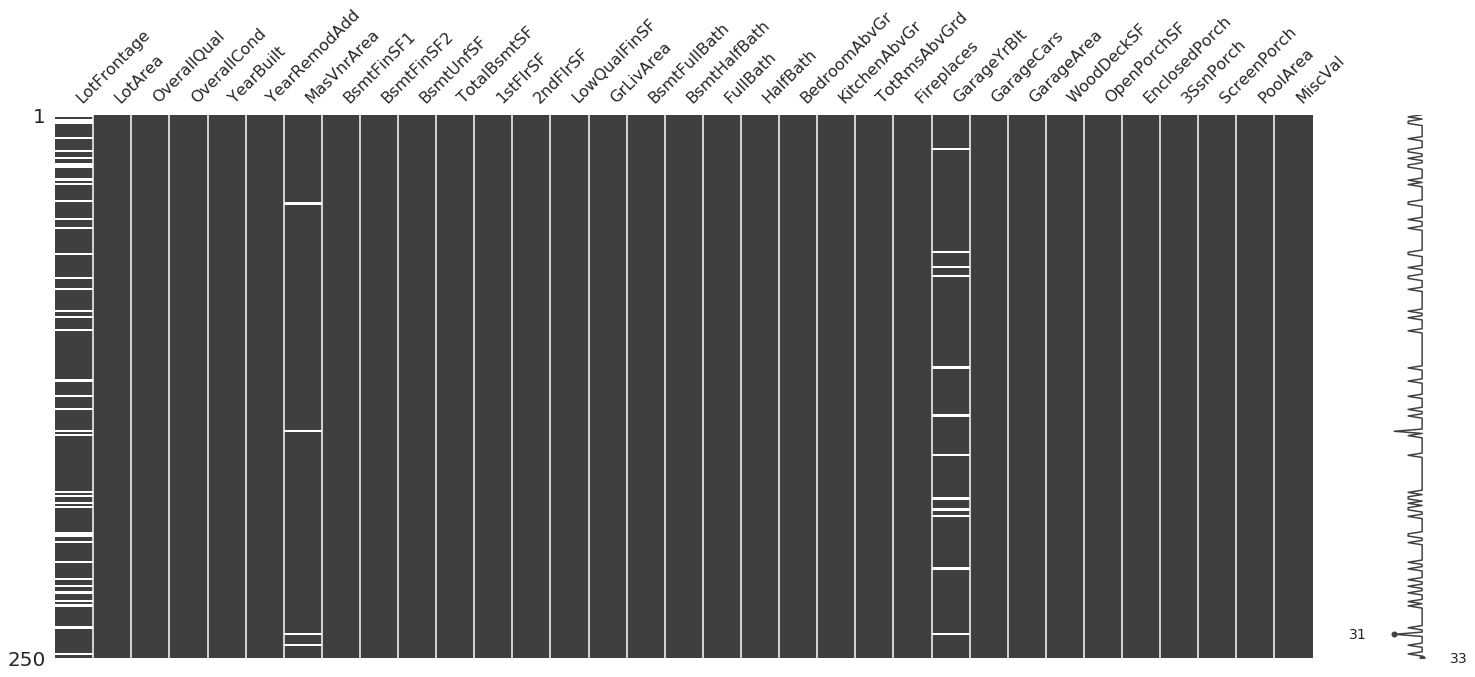

In [17]:
#Visualising missing values for a sample of 250 from numeric_features dataframe
msno.matrix(numeric_features.sample(250));

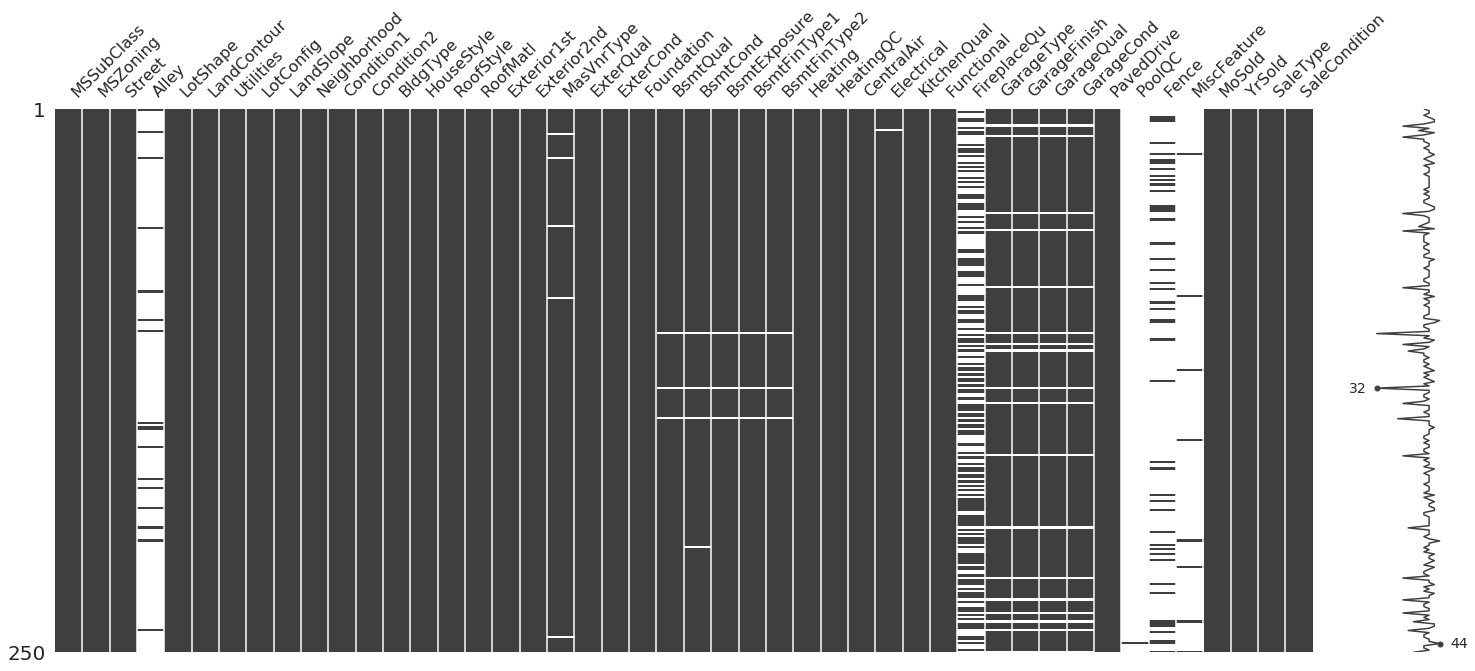

In [18]:
#Visualising missing values for a sample of 250 from categorical_features dataframe 
msno.matrix(categorical_features.sample(250));

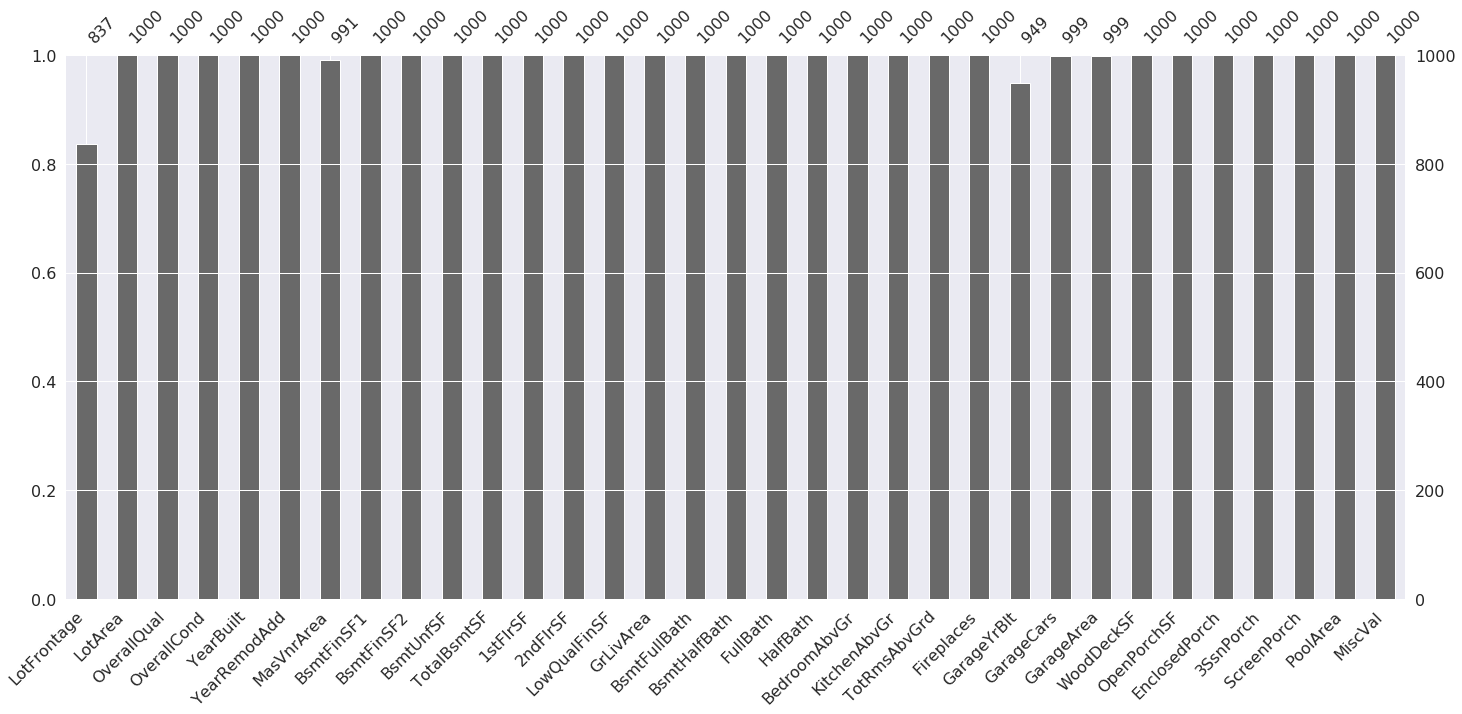

In [19]:
#Visualising missing values for a sample of 1000 from numeric_features dataframe 
msno.bar(numeric_features.sample(1000));

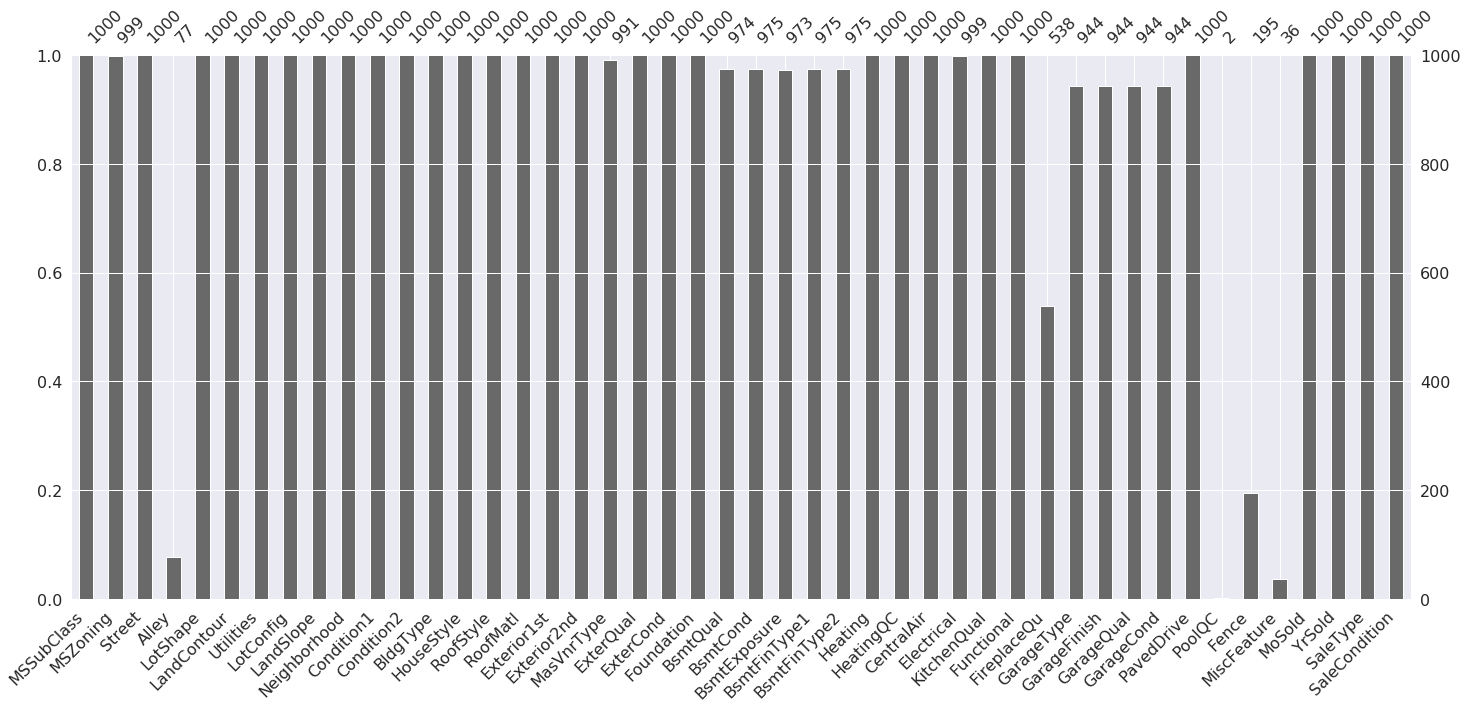

In [20]:
#Visualising missing values for a sample of 1000 from categorical_features dataframe 
msno.bar(categorical_features.sample(1000));

- #### Missing values visualization dependence 
`Missingno` correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another

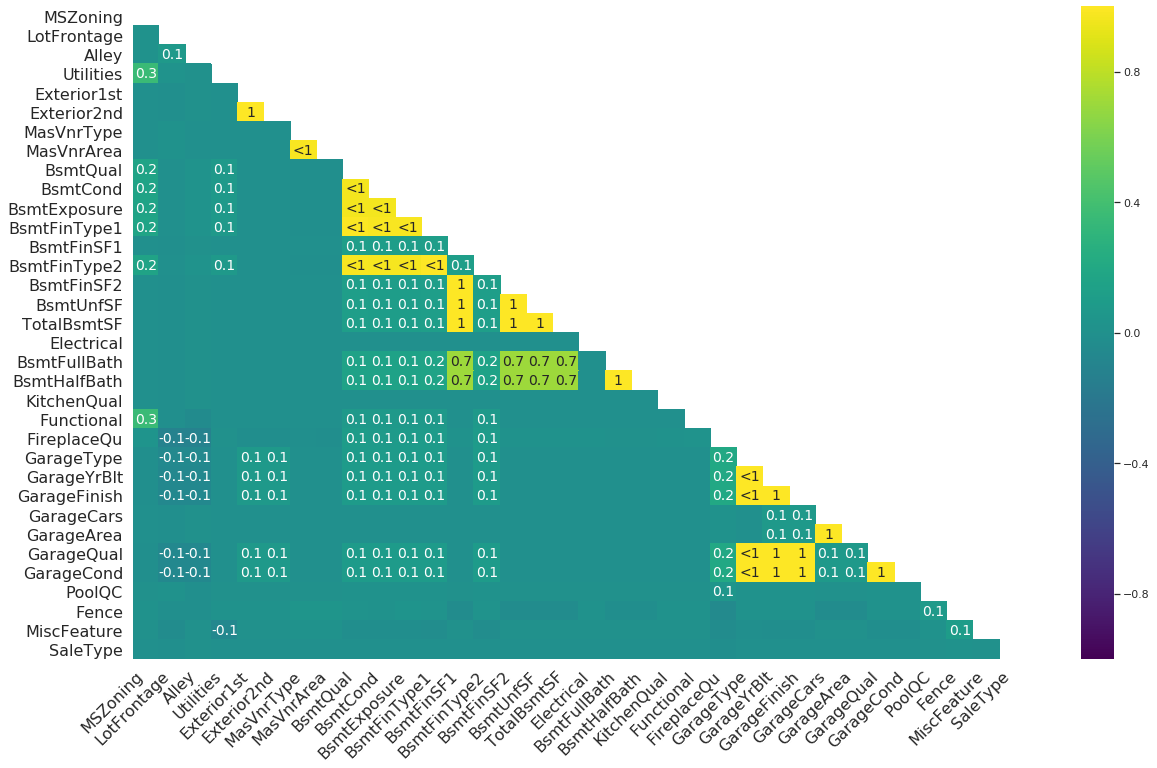

In [21]:
msno.heatmap(all_features, cmap='viridis')
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show();

The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap.

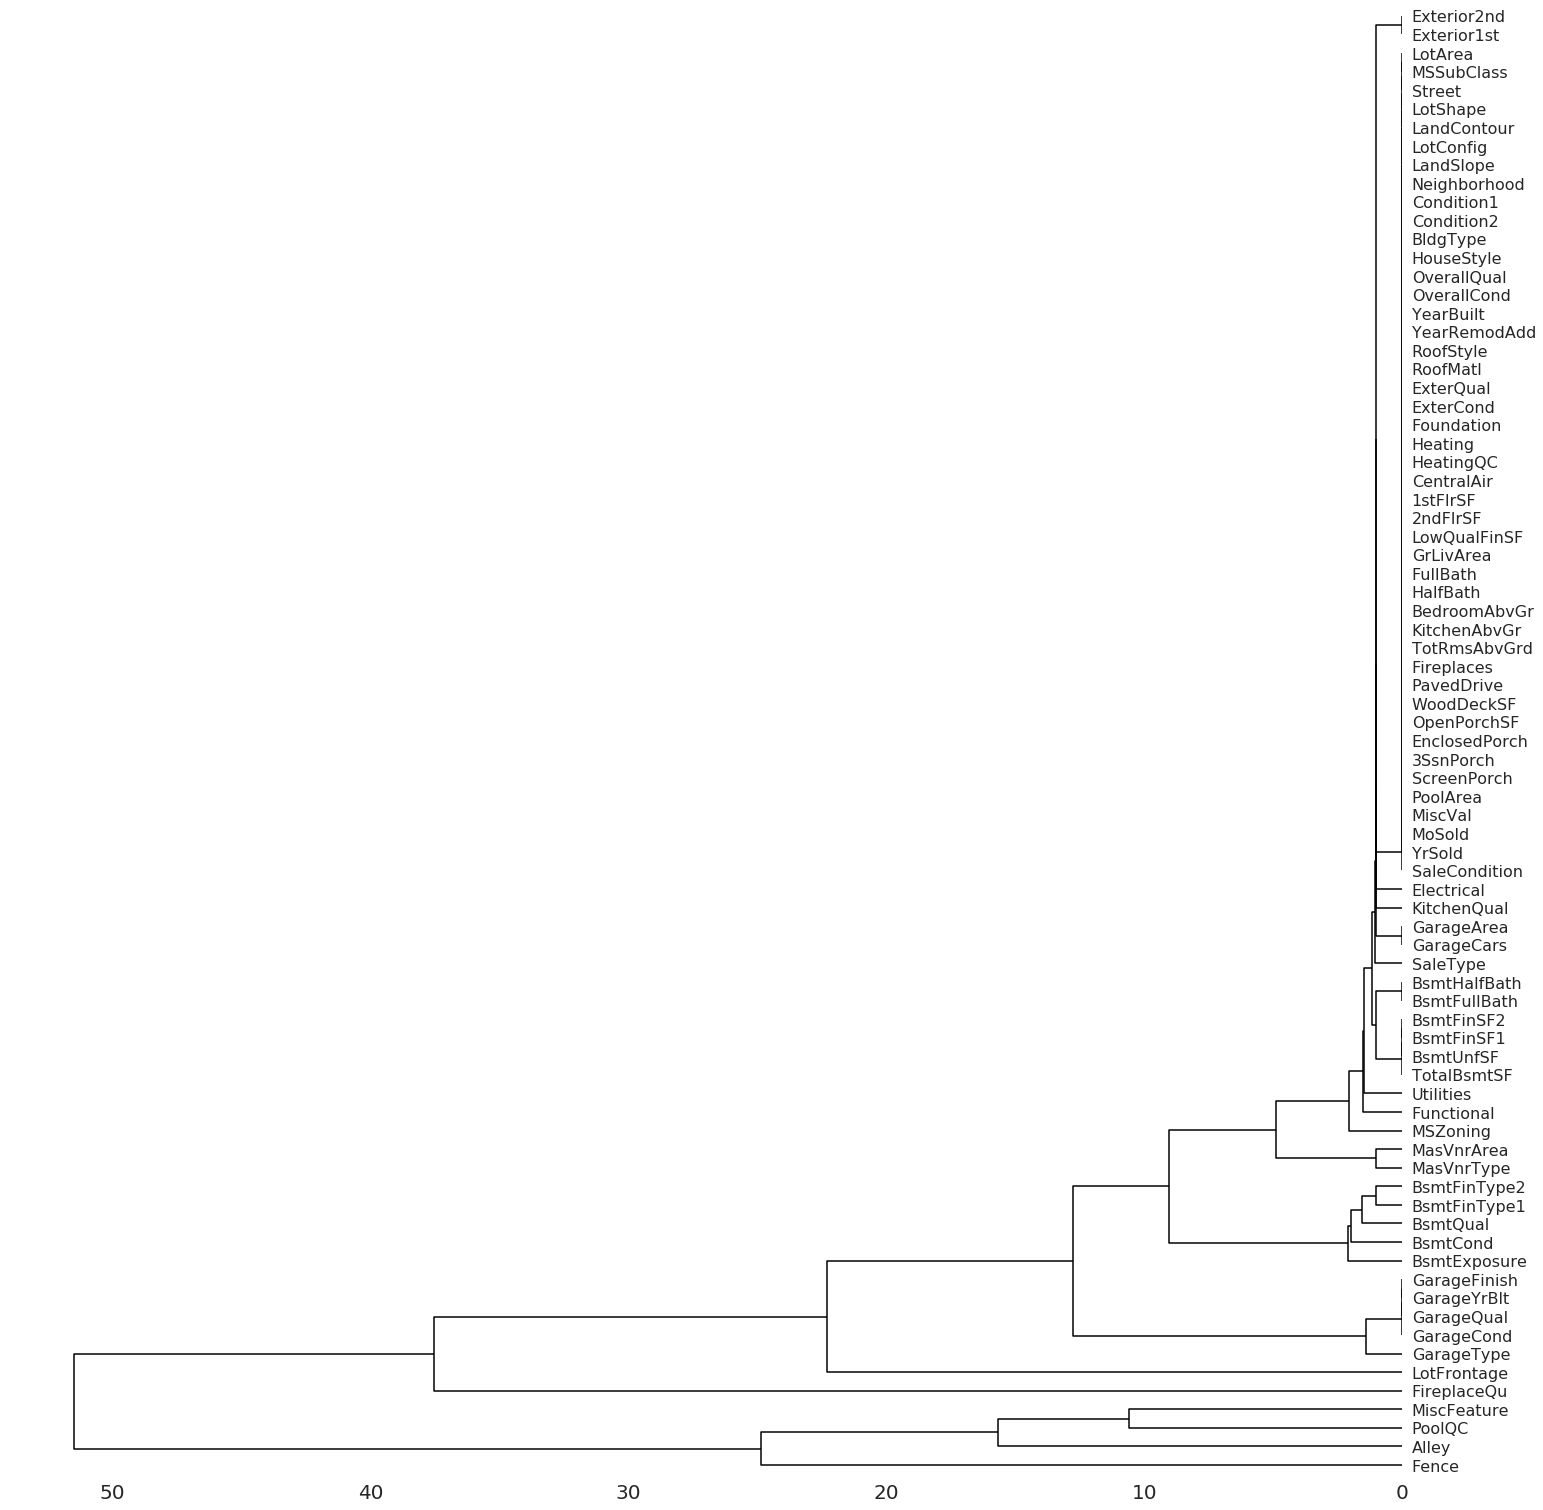

In [22]:
msno.dendrogram(all_features);

The dendrogram uses a scipy hierarchical clustering algorithm to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and present in every record.

Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If your own interpretation of the dataset is that these columns actually are or ought to match each other in nullity , then the height of the cluster leaf tells you, in absolute terms, how often the records are "mismatched" or incorrectly filed—that is, how many values you would have to fill in or drop, if you are so inclined.

As with matrix, only up to 50 labeled columns will comfortably display in this configuration. However the dendrogram more elegantly handles extremely large datasets by simply flipping to a horizontal configuration.

In [23]:
# Craete sorted dataframe of numeric_features with missing_count
missing_values0 = numeric_features.isnull().sum(axis=0).reset_index()
missing_values0.columns = ['column_name', 'missing_count']
missing_values0 = missing_values0.loc[missing_values0['missing_count']>0]
missing_values0 = missing_values0.sort_values(by='missing_count')

In [24]:
# Get percantage of total NaNs numeric_features
total0 = numeric_features.isnull().sum().sort_values(ascending=False)
percent0 = (numeric_features.isnull().sum()/numeric_features.isnull().count()).sort_values(ascending=False)
missing_data0 = pd.concat([total0, percent0], axis=1,join='outer', keys=['Total Missing Count', '% of Total Observations'])
missing_data0.index.name =' Numeric Feature'

missing_data0.head(15)

Total Missing Count  % of Total Observations
 Numeric Feature                                              
LotFrontage                       485                 0.166324
GarageYrBlt                       159                 0.054527
MasVnrArea                         23                 0.007888
BsmtFullBath                        2                 0.000686
BsmtHalfBath                        2                 0.000686
GarageArea                          1                 0.000343
GarageCars                          1                 0.000343
BsmtFinSF1                          1                 0.000343
BsmtFinSF2                          1                 0.000343
BsmtUnfSF                           1                 0.000343
TotalBsmtSF                         1                 0.000343
OpenPorchSF                         0                 0.000000
2ndFlrSF                            0                 0.000000
LotArea                             0                 0.000000
OverallQual                         0                 0.000000

In [25]:
# Craete sorted dataframe of categorical_features with missing_count
missing_values1 = categorical_features.isnull().sum(axis=0).reset_index()
missing_values1.columns = ['column_name', 'missing_count']
missing_values1 = missing_values1.loc[missing_values1['missing_count']>0]
missing_values1 = missing_values1.sort_values(by='missing_count')

In [26]:
# Get percantage of total NaNs categorical_features
total1 = categorical_features.isnull().sum().sort_values(ascending=False)
percent1 = (categorical_features.isnull().sum()/categorical_features.isnull().count()).sort_values(ascending=False)
missing_data1 = pd.concat([total1, percent1], axis=1,join='outer', keys=['Total Missing Count', ' % of Total Observations'])
missing_data1.index.name ='Feature'
missing_data1.head(25)

Total Missing Count   % of Total Observations
Feature                                                    
PoolQC                       2907                  0.996914
MiscFeature                  2811                  0.963992
Alley                        2718                  0.932099
Fence                        2345                  0.804184
FireplaceQu                  1420                  0.486968
GarageCond                    159                  0.054527
GarageQual                    159                  0.054527
GarageFinish                  159                  0.054527
GarageType                    157                  0.053841
BsmtCond                       82                  0.028121
BsmtExposure                   82                  0.028121
BsmtQual                       81                  0.027778
BsmtFinType2                   80                  0.027435
BsmtFinType1                   79                  0.027092
MasVnrType                     24                  0.008230
MSZoning                        4                  0.001372
Functional                      2                  0.000686
Utilities                       2                  0.000686
KitchenQual                     1                  0.000343
Electrical                      1                  0.000343
Exterior1st                     1                  0.000343
Exterior2nd                     1                  0.000343
SaleType                        1                  0.000343
Neighborhood                    0                  0.000000
Condition1                      0                  0.000000

#### Plot Missing count bars

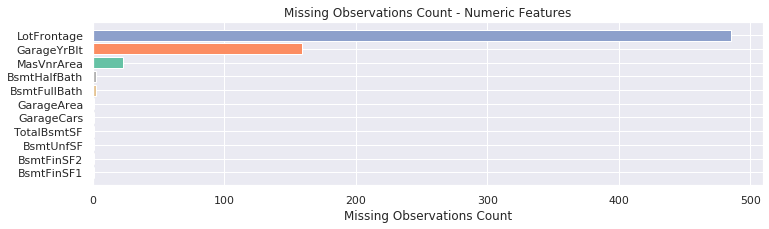

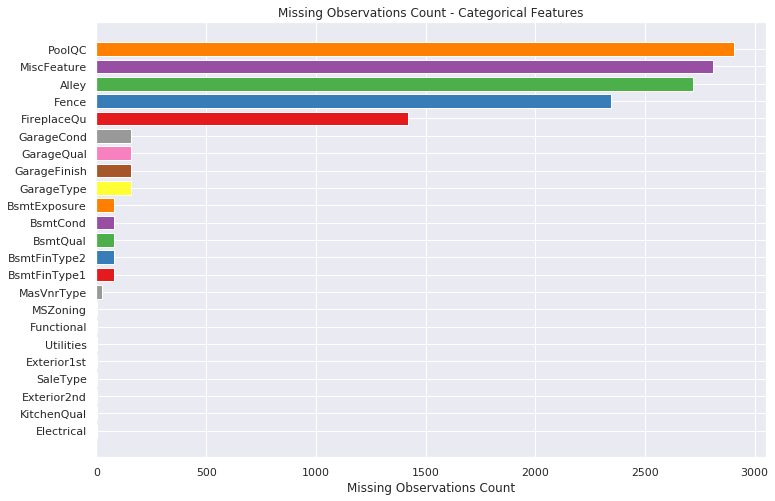

In [27]:
ind0 = np.arange(missing_values0.shape[0])
width0 = 0.1
fig, ax = plt.subplots(figsize=(12,3))
colors0 = sns.color_palette('Set2', len(ind0))
rects0 = ax.barh(ind0, missing_values0.missing_count.values, color=colors0)
ax.set_yticks(ind0)
ax.set_yticklabels(missing_values0.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Observations Count - Numeric Features")
plt.show()

ind1 = np.arange(missing_values1.shape[0])
width1 = 0.9
fig, ax = plt.subplots(figsize=(12,8))
colors1 = sns.color_palette('Set1', len(ind1))
rects1 = ax.barh(ind1, missing_values1.missing_count.values, color=colors1)
ax.set_yticks(ind1)
ax.set_yticklabels(missing_values1.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Observations Count - Categorical Features")
plt.show()

## Numeric data distributions

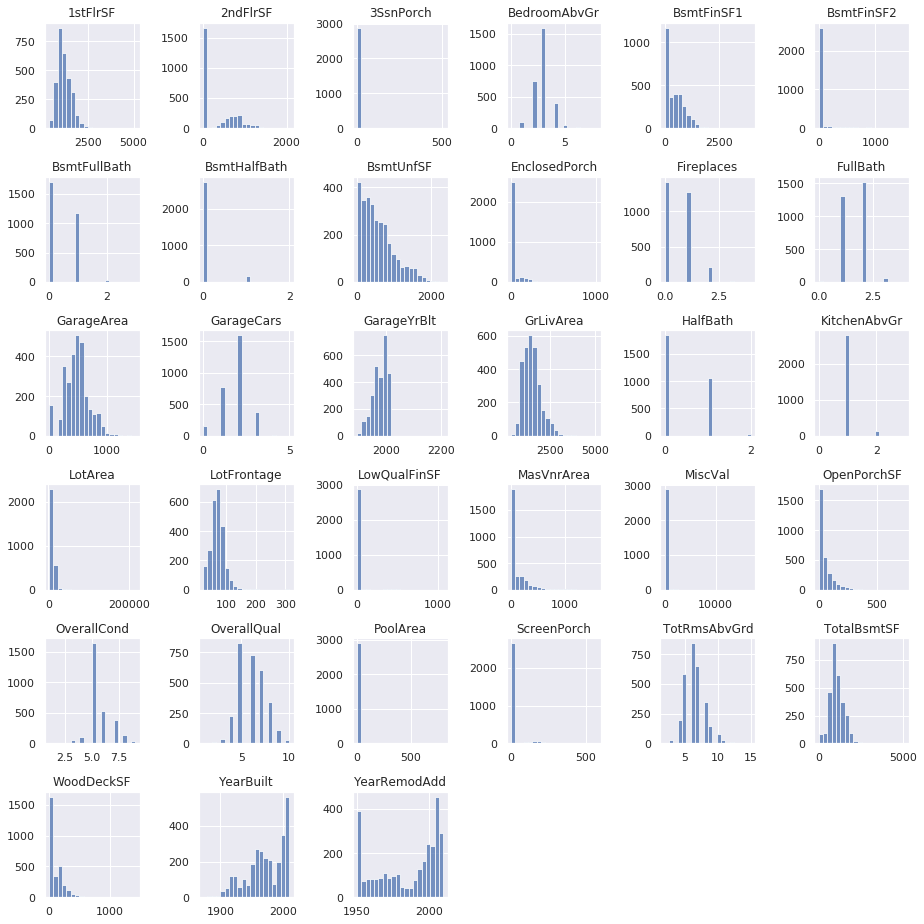

In [28]:
numeric_features.hist(bins=20, figsize=(13,13), alpha=0.75)
plt.tight_layout()
plt.show();

### Skew Kurtosis and Variance 

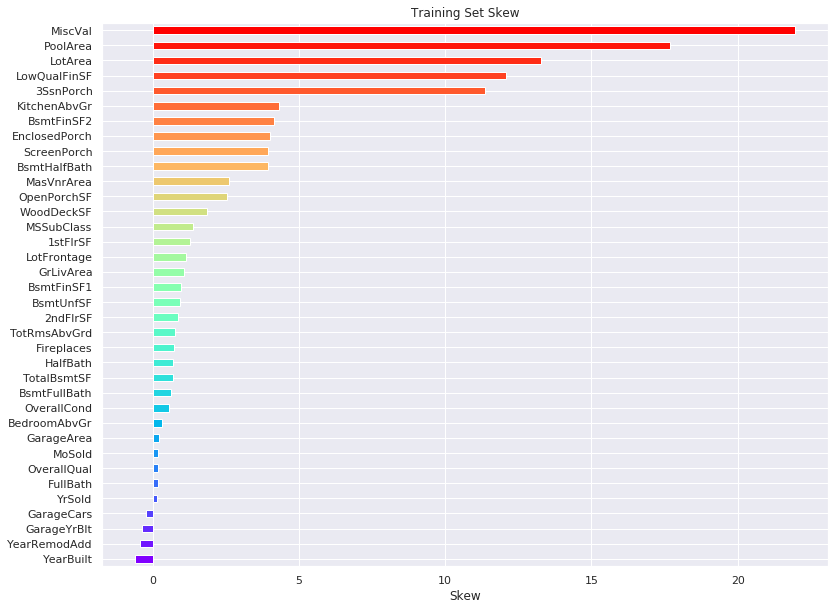

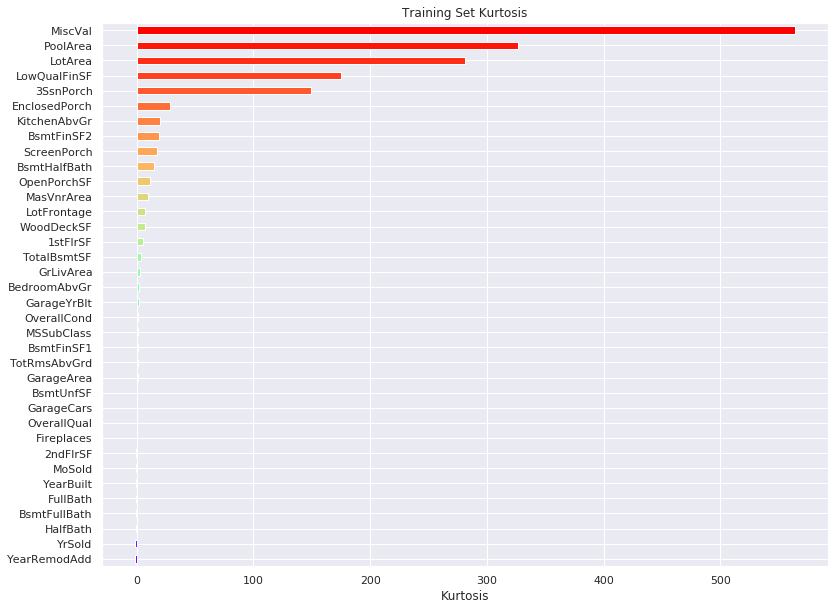

Traing Set Feature Variance
KitchenAbvGr     4.603924e-02
BsmtHalfBath     6.042034e-02
HalfBath         2.528269e-01
BsmtFullBath     2.745608e-01
FullBath         3.052113e-01
Fireplaces       4.151992e-01
GarageCars       5.801090e-01
BedroomAbvGr     6.772532e-01
OverallCond      1.240051e+00
OverallQual      1.978002e+00
TotRmsAbvGrd     2.447746e+00
YearRemodAdd     4.366035e+02
LotFrontage      5.194624e+02
3SsnPorch        6.350898e+02
GarageYrBlt      6.539180e+02
YearBuilt        9.175139e+02
PoolArea         1.194897e+03
LowQualFinSF     2.154858e+03
ScreenPorch      3.159666e+03
EnclosedPorch    4.131021e+03
OpenPorchSF      4.503739e+03
WoodDeckSF       1.601017e+04
BsmtFinSF2       2.865748e+04
MasVnrArea       3.187336e+04
GarageArea       4.607683e+04
1stFlrSF         1.483919e+05
2ndFlrSF         1.833106e+05
TotalBsmtSF      1.841611e+05
BsmtUnfSF        1.933263e+05
BsmtFinSF1       1.972083e+05
GrLivArea        2.469936e+05
MiscVal          3.222739e+05
LotArea     

In [29]:
skw = all_features.skew().sort_values()
colors = cm.rainbow(np.linspace(0, 1, len(skw)))
skw.plot.barh(colors=colors, figsize=(13, 10))
plt.title('Training Set Skew')
plt.xlabel('Skew')
plt.show();

krt = all_features.kurt().sort_values()
colors = cm.rainbow(np.linspace(0, 1, len(krt)))
krt.plot.barh(colors=colors, figsize=(13, 10))
plt.title('Training Set Kurtosis')
plt.xlabel('Kurtosis')
plt.show();

var = all_features.var().sort_values()
print('Traing Set Feature Variance')
print(var)

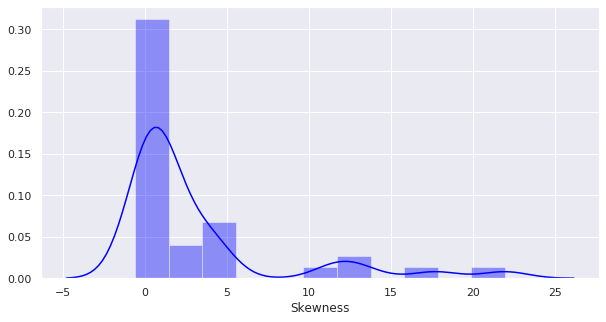

In [30]:
sns.distplot(all_features.skew(),color='blue',axlabel ='Skewness');

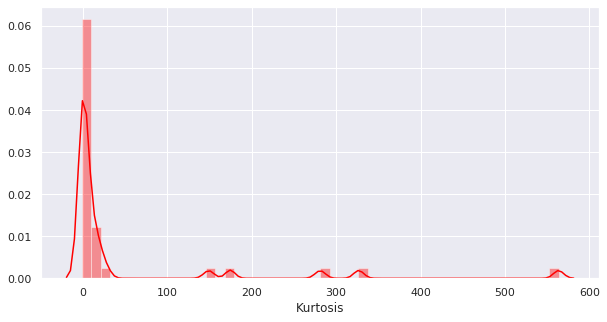

In [31]:
sns.distplot(all_features.kurt(),color='red', axlabel ='Kurtosis', norm_hist=False, kde=True, rug=False);

#### Fit Target to distribution 

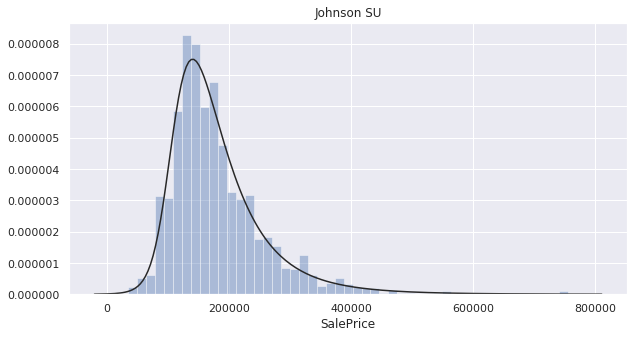

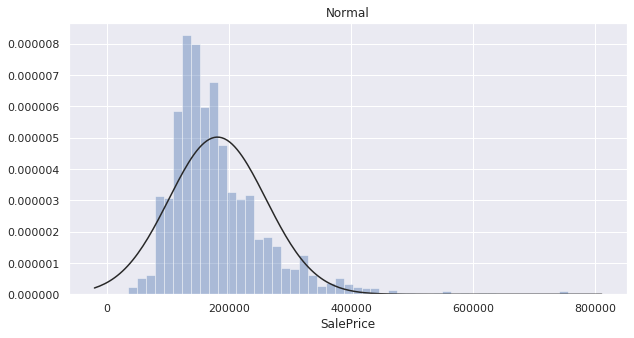

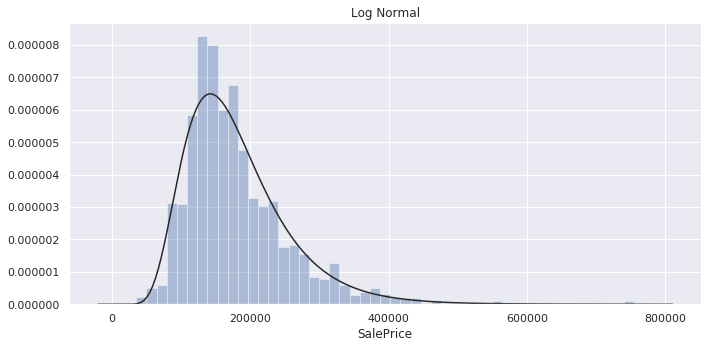

In [32]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)
plt.tight_layout()
plt.show();

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

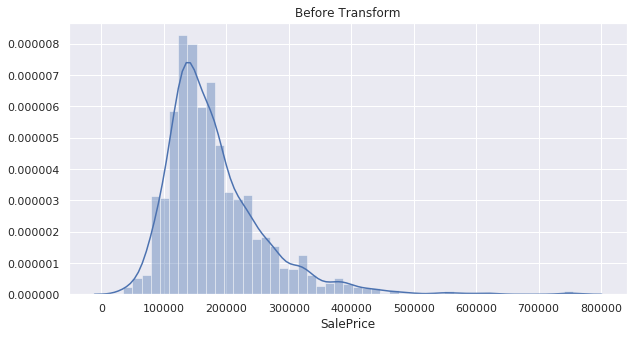

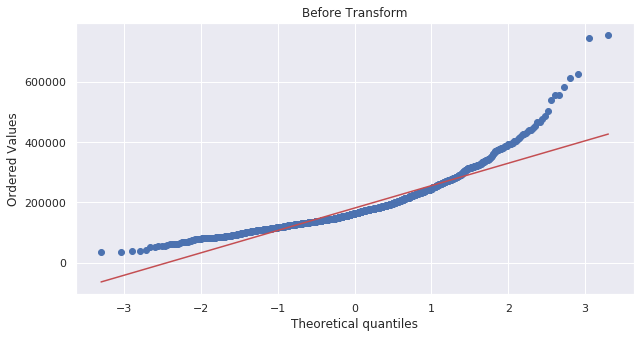

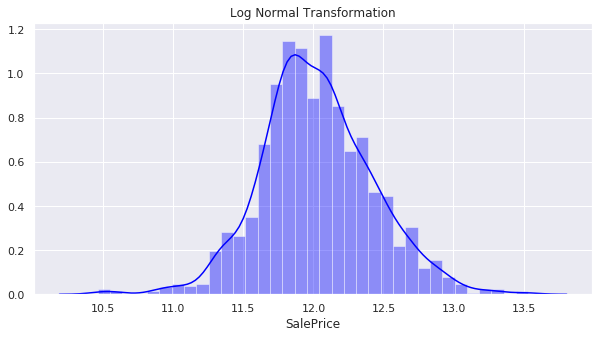

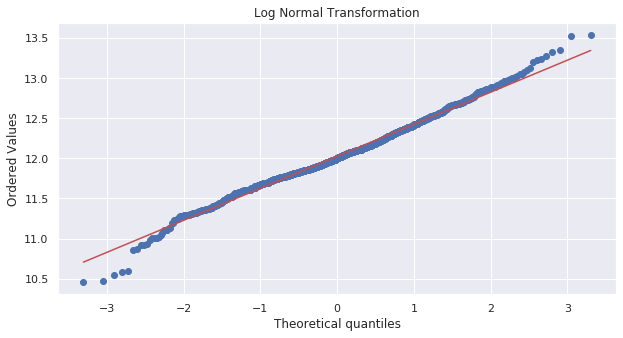

In [33]:
sns.distplot(train['SalePrice'])
plt.title('Before Transform')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
stats.probplot(train['SalePrice'], fit=True, plot=ax)
plt.title('Before Transform')
plt.show();

train_target = np.log1p(train['SalePrice'])
sns.distplot(train_target,color='blue')
plt.title('Log Normal Transformation')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
stats.probplot(train_target, fit=True, plot=ax)
plt.title('Log Normal Transformation')
plt.show();

Looking at pairwise correlations 

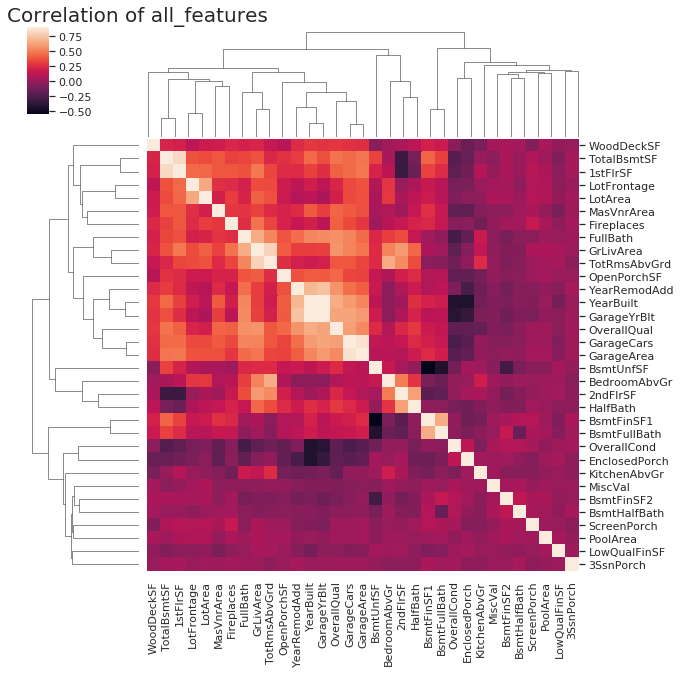

In [34]:
correlation = all_features.corr(method='spearman')

g = sns.clustermap(correlation, square=True,  vmax=0.9)
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation of all_features',y=1, x=5,size=20)
plt.show();

   **Squares that get my attention**

1. The first are the `'TotalBsmtSF'` and `'1stFlrSF'` variables.

2. The second are the `'GarageCars'` and `'GarageArea'` variables.

3. The third are the `'YearBuilt'` and `'GarageYrBlt'` variables.

3. The third are the `'GrLivArea'` and `'TotRmsAbvGrd'` variables.


All cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity occurs.

Heatmaps are great to detect this kind of multicollinearity situations and in problems related to feature selection like this project.

**Heatmap of the 13 most highly correlated features to the target**

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt',
       'GarageArea', 'FullBath', 'TotalBsmtSF', 'GarageYrBlt', '1stFlrSF',
       'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces'],
      dtype='object')


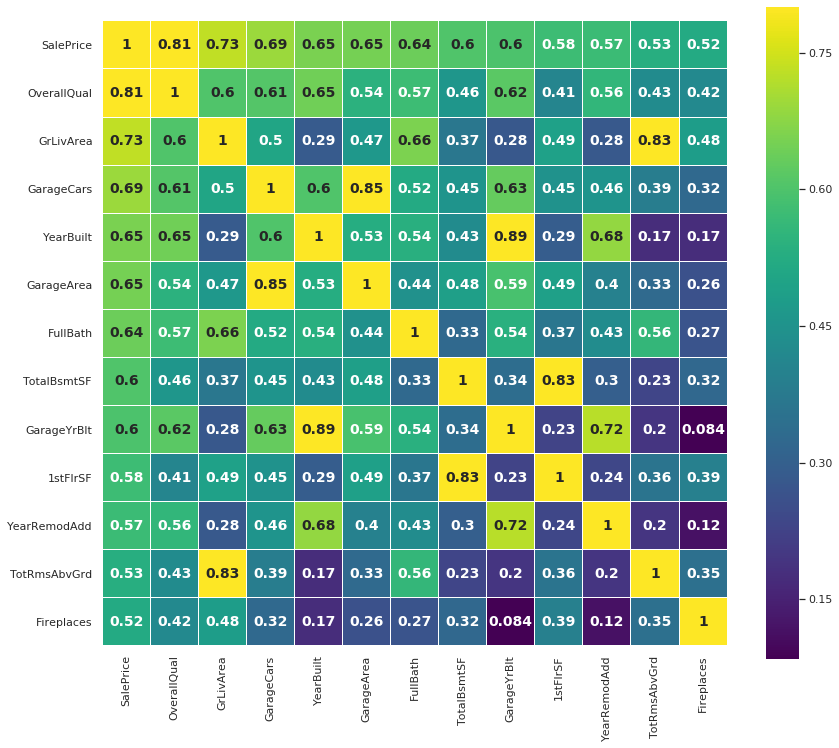

In [35]:
tmp_fts = all_features.copy()
tmp_fts['SalePrice'] = train.SalePrice
correlation_num = tmp_fts.corr(method='spearman')

k= 13
cols = correlation_num.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(train[cols].corr(method='spearman'), vmax=.8, linewidths=0.01, square=True, annot=True, cmap='viridis',
            linecolor="white", annot_kws = {'size':14, 'fontweight':'bold'})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

From above zoomed heatmap it is observed that `GarageCars` & `GarageArea` are closely correlated . Similarly `TotalBsmtSF` & `1stFlrSF` are also closely correlated & `YearBuilt` & `GarageYrBuild` are closely correlated.

**Sorted features correlation to target**

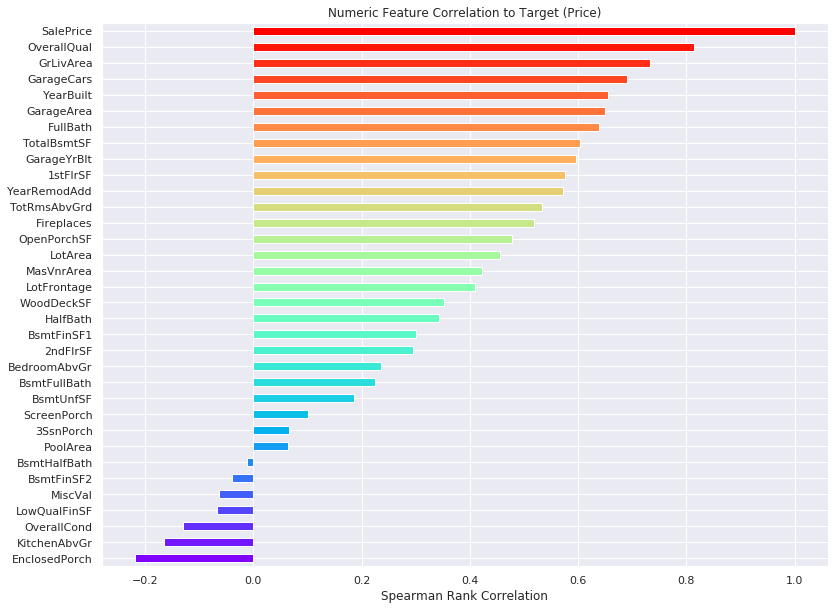

In [36]:
colors = cm.rainbow(np.linspace(0, 1, len(correlation_num)))
correlation_num['SalePrice'].sort_values().plot.barh(colors=colors, figsize=(13, 10))
plt.title('Numeric Feature Correlation to Target (Price)')
plt.xlabel('Spearman Rank Correlation')
plt.show();

In [37]:
correlation_num['SalePrice'].sort_values(ascending=False).drop('SalePrice').head(10)

OverallQual     0.813513
GrLivArea       0.732349
GarageCars      0.691027
YearBuilt       0.654729
GarageArea      0.650251
FullBath        0.637819
TotalBsmtSF     0.603140
GarageYrBlt     0.596326
1stFlrSF        0.575615
YearRemodAdd    0.572053
Name: SalePrice, dtype: float64

In [38]:
correlation_num['SalePrice'].sort_values(ascending=True).drop('SalePrice').head(10)

EnclosedPorch   -0.218120
KitchenAbvGr    -0.164694
OverallCond     -0.129749
LowQualFinSF    -0.067635
MiscVal         -0.062576
BsmtFinSF2      -0.038334
BsmtHalfBath    -0.011817
PoolArea         0.063723
3SsnPorch        0.065669
ScreenPorch      0.100517
Name: SalePrice, dtype: float64

My observations :

- `'GarageCars'` and `'GarageArea'` are strongly correlated variables. It is because the number of cars that fit into the garage is a consequence of the garage area. `'GarageCars'` and `'GarageArea'` are like twin brothers. So it is hard to distinguish between the two. Therefore, we just need one of these variables in our analysis (we can keep `'GarageCars'` since its correlation with `'SalePrice'` is higher).
- `'TotalBsmtSF'` and `'1stFloor'` also seem to be twins. In this case let us keep `'TotalBsmtSF'`
- `'TotRmsAbvGrd'` and `'GrLivArea'`, twins. In this case let us keep `'GrLivArea'`
- `'YearBuilt'` and `'GarageYrBlt'`, twins. In this case let us keep `'YearBuilt'`
- `'YearBuilt'` it appears like is slightly correlated with `'SalePrice'`. This required more analysis to arrive at a conclusion may be do some time series analysis.

**Pair Plot Pair Plot between 'SalePrice' and correlated variables**

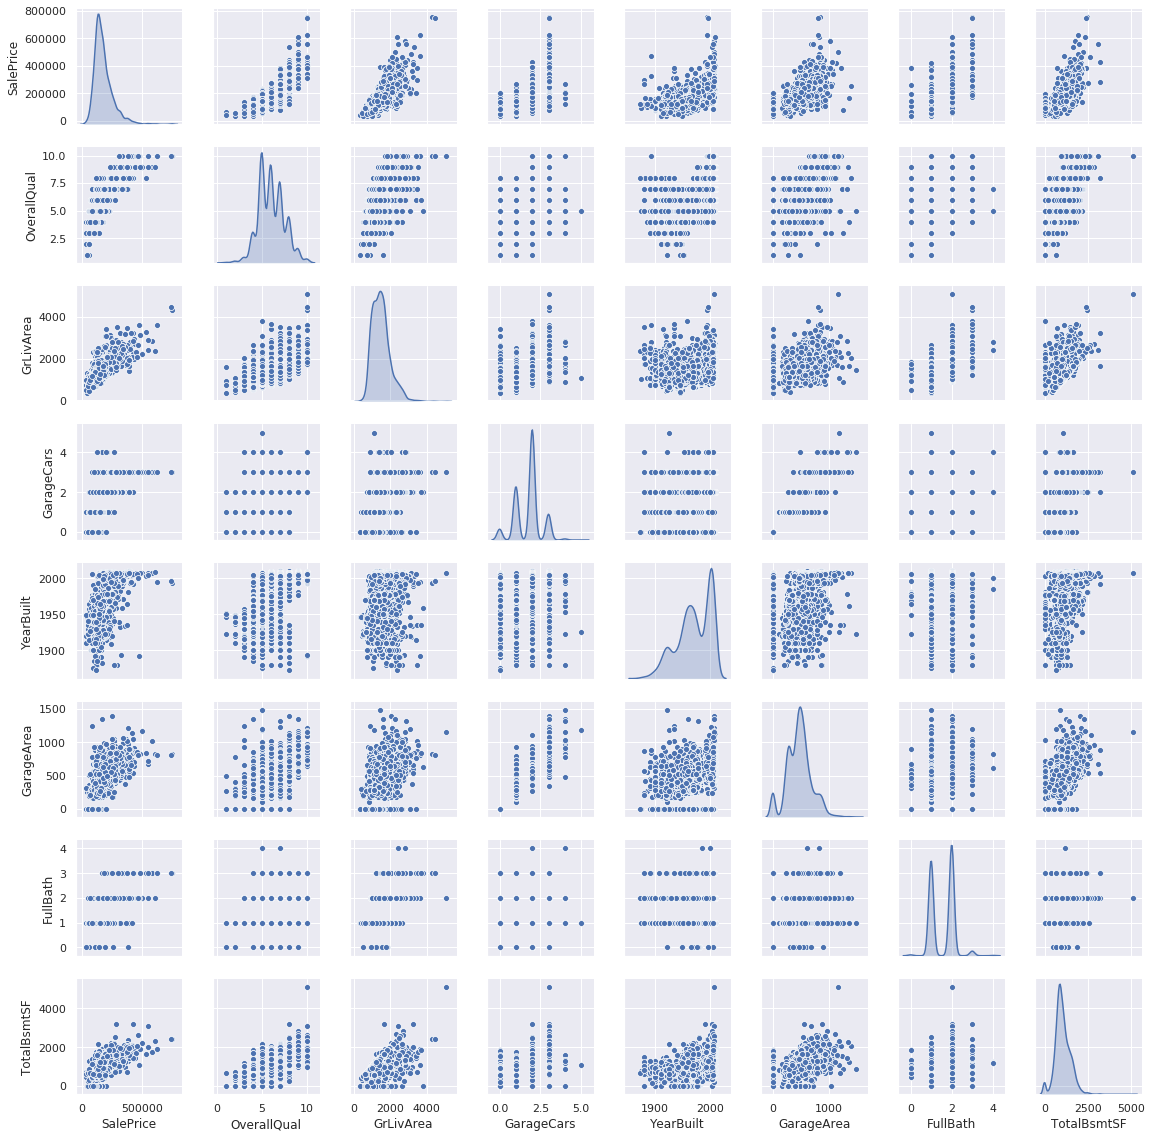

In [39]:
columns = ['SalePrice','OverallQual','GrLivArea','GarageCars','YearBuilt','GarageArea','FullBath', 'TotalBsmtSF']
sns.pairplot(tmp_fts[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

Although we already know some of the main figures, this pair plot gives us a reasonable overview insight about the correlated features .Here are some of my analysis.

- One interesting observation is between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.

- One more interesting observation is between 'SalePrice' and 'YearBuilt'. In the bottom of the 'dots cloud', we see what almost appears to be a exponential function.We can also see this same tendency in the upper limit of the 'dots cloud'

- Last observation is that prices are increasing faster now with respect to previous years.

**Scatter Plot between numerical variables and Target**

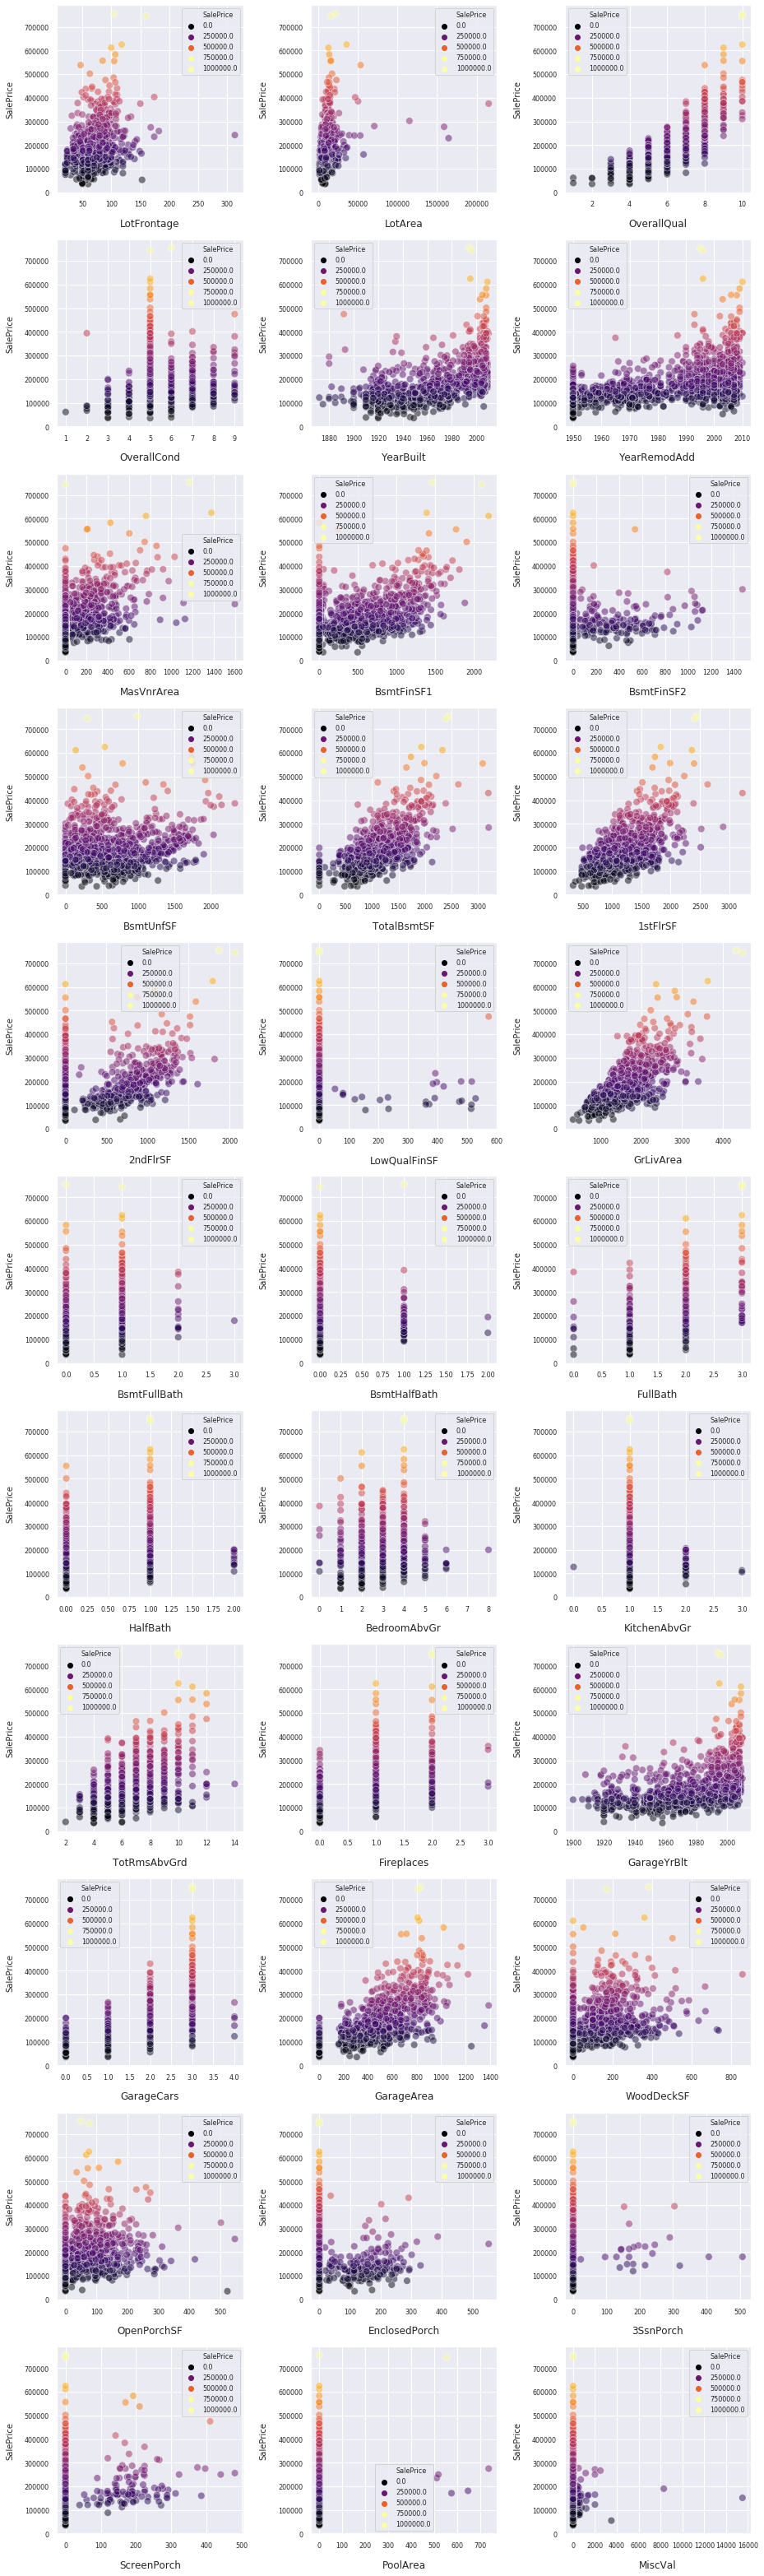

In [40]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(13, 130))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(list(tmp_fts[numeric_features.columns]), 1):
    if(feature=='SalePrice'):
        break
    plt.subplot(len(list(tmp_fts[numeric_features.columns].columns)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='inferno', data=tmp_fts, s=75, alpha=0.5)
        
    plt.xlabel(f'{feature}', size=15,labelpad=12.5, fontsize=12)
    plt.ylabel('SalePrice', size=15, labelpad=12.5, fontsize=10)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=8)
        plt.tick_params(axis='y', labelsize=8)
    
    plt.legend(loc='best', prop={'size': 8})
    
plt.tight_layout()       
plt.show()

Although we already know some of the main figures, this pair plot gives us a reasonable overview insight about the correlated features .Here are some of my analysis.

One interesting observation is between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.

One more interesting observation is between 'SalePrice' and 'YearBuilt'. In the bottom of the 'dots cloud', we see what almost appears to be a exponential function.We can also see this same tendency in the upper limit of the 'dots cloud'

Last observation is that prices are increasing faster now with respect to previous years.

#### Box plot and Countplot - Numerical

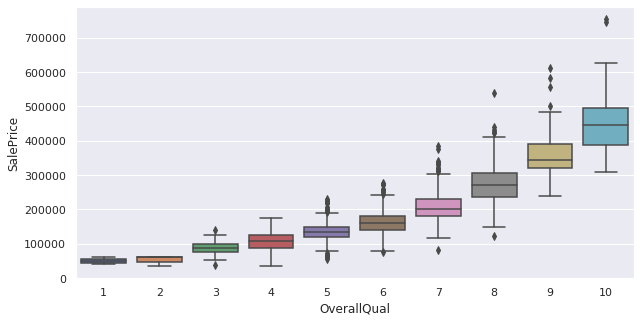

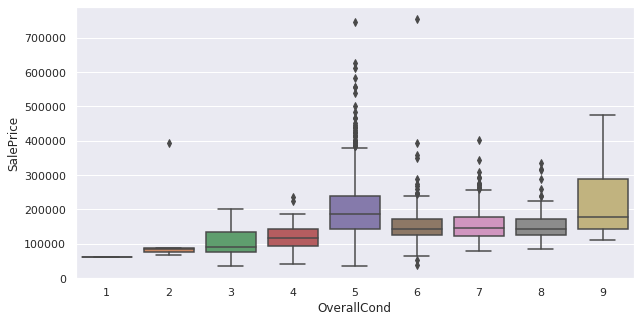

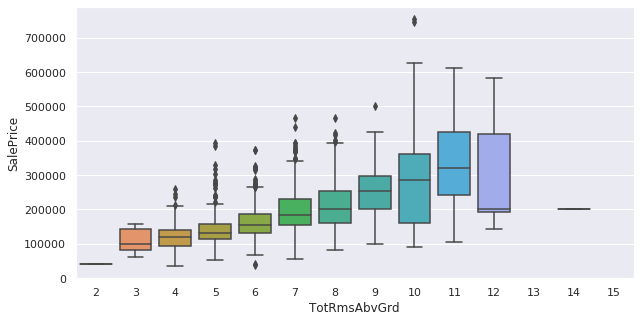

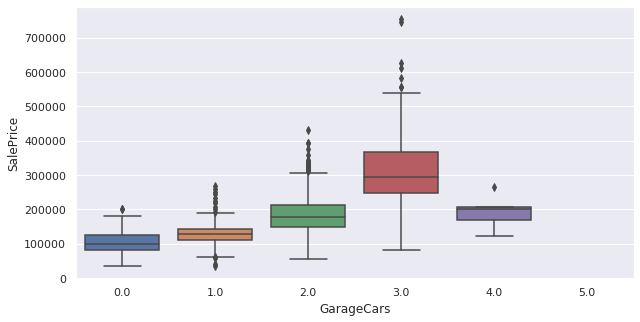

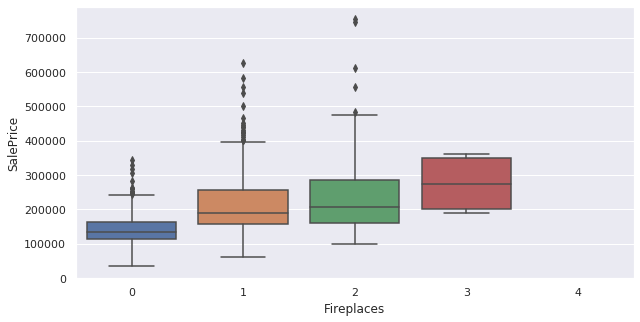

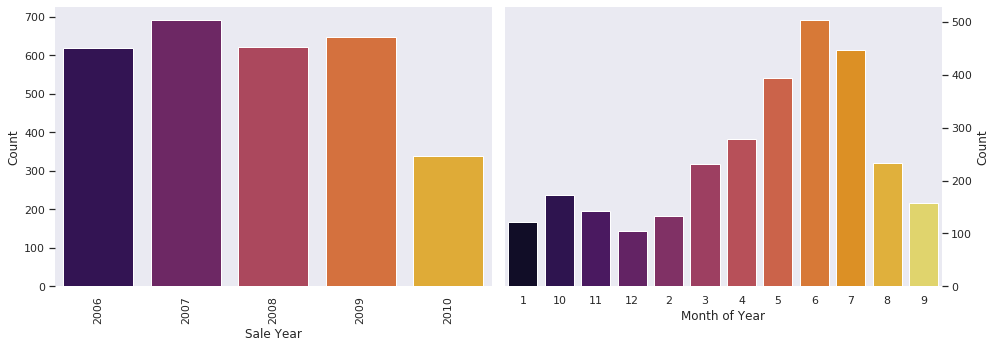

In [41]:
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='OverallQual', y="SalePrice", data=tmp_fts)
plt.show()

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='OverallCond', y="SalePrice", data=tmp_fts)
plt.show()

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='TotRmsAbvGrd', y="SalePrice", data=tmp_fts)
plt.show()

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='GarageCars', y="SalePrice", data=tmp_fts)
plt.show()


f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Fireplaces', y="SalePrice", data=tmp_fts)
plt.show()

f, axes = plt.subplots(1, 2,figsize=(14,5))
axes[0].grid(False)
axes[1].grid(False)
sns.despine(left=True, bottom=True)
g = sns.countplot(tmp_fts['YrSold'], ax=axes[0], palette='inferno', data=tmp_fts)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
sns.countplot(tmp_fts['MoSold'], ax=axes[1], palette='inferno', data=tmp_fts)
axes[1].set(xlabel='Month of Year', ylabel='Count')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[0].set(xlabel='Sale Year', ylabel='Count')
plt.tight_layout()
plt.show();

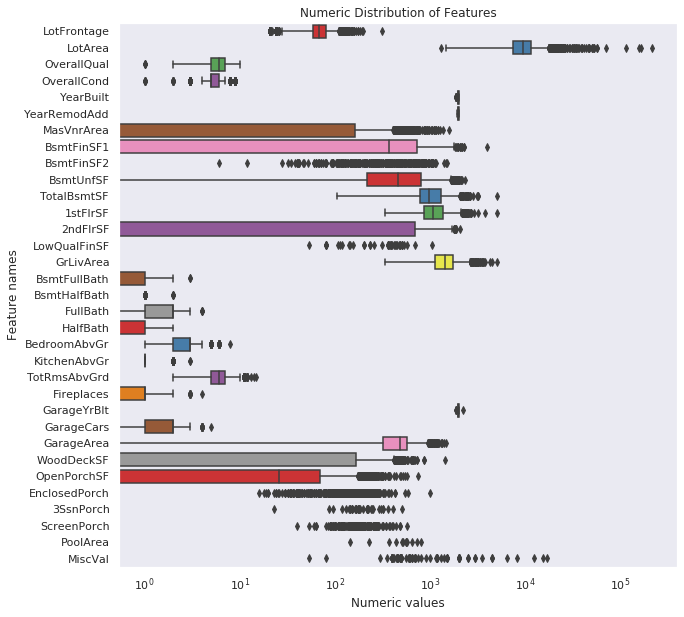

In [42]:
# Create box plots for all numeric features
f, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log")
ax = sns.boxplot(data=tmp_fts[numeric_features.columns] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
plt.show();

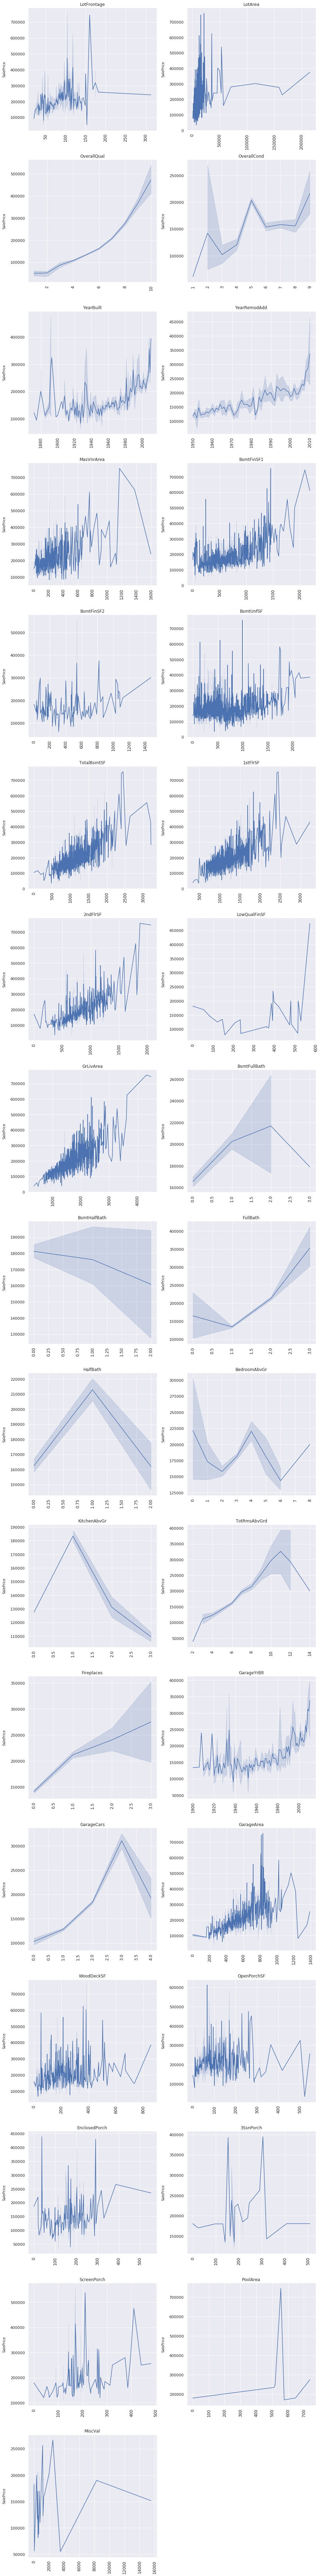

In [43]:
# vizualising numerical features time series vs target 
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(13, 200))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(list(tmp_fts[numeric_features.columns]), 1):
    if(feature=='SalePrice'):
        break
    plt.subplot(len(list(tmp_fts[numeric_features.columns].columns)), 2, i)
    sns.lineplot(x=feature, y='SalePrice', data=tmp_fts)
        
    plt.title(f'{feature}', size=15, fontsize=12)
    plt.ylabel('SalePrice', size=15, labelpad=12.5,fontsize=10)
    plt.xlabel('')
    plt.xticks(rotation=90,fontsize=12)
    
plt.tight_layout()
plt.show()

#### Box plot - Categorical

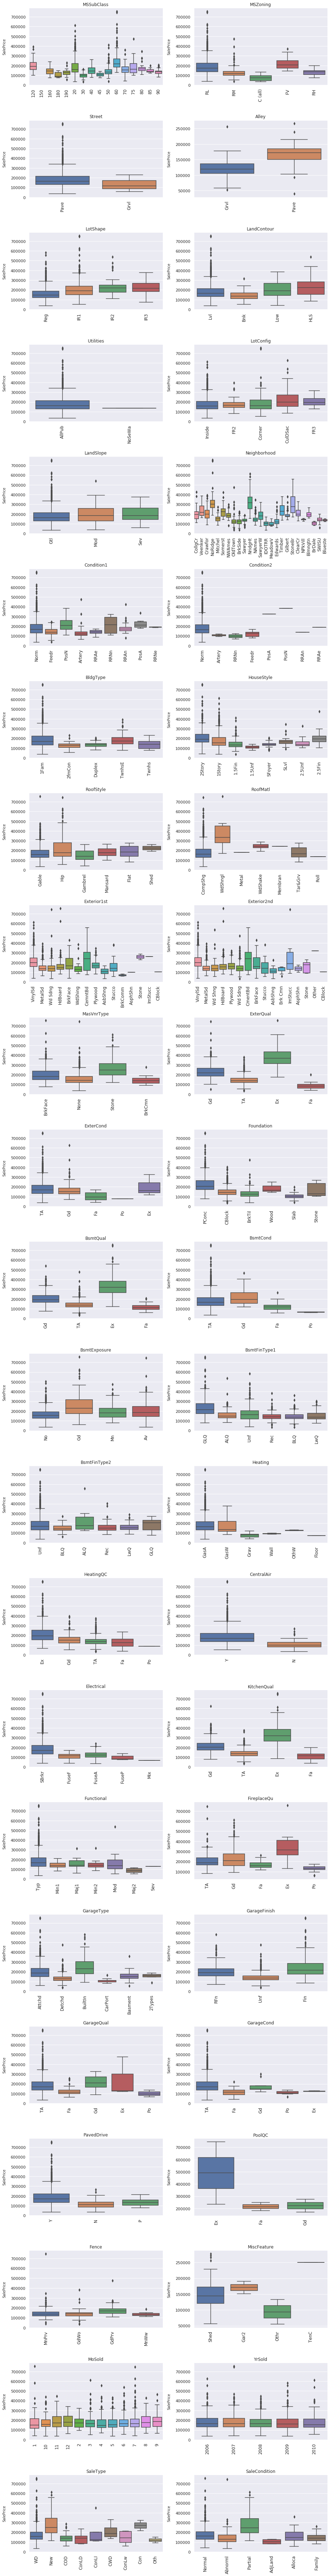

In [44]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(13, 200))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(list(tmp_fts[categorical_features.columns]), 1):
    if(feature=='SalePrice'):
        break
    plt.subplot(len(list(tmp_fts[categorical_features.columns].columns)), 2, i)
    sns.boxplot(x=feature, y='SalePrice', data=tmp_fts)
        
    plt.title(f'{feature}', size=15, fontsize=12)
    plt.ylabel('SalePrice', size=15, labelpad=12.5,fontsize=10)
    plt.xlabel('')
    plt.xticks(rotation=90,fontsize=12)
    
plt.tight_layout()
plt.show()

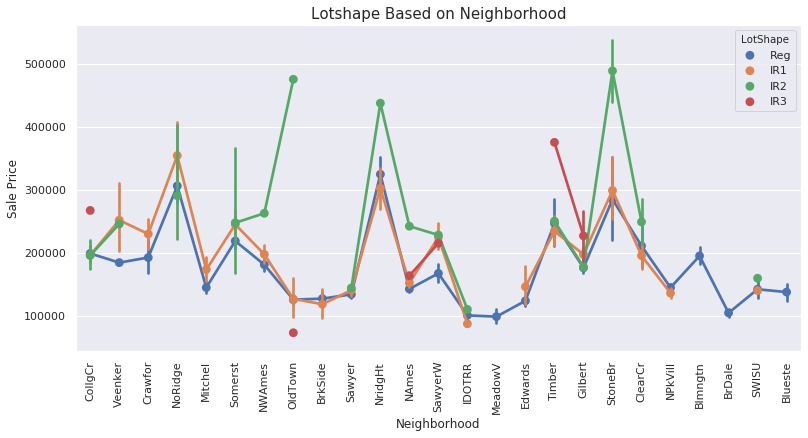

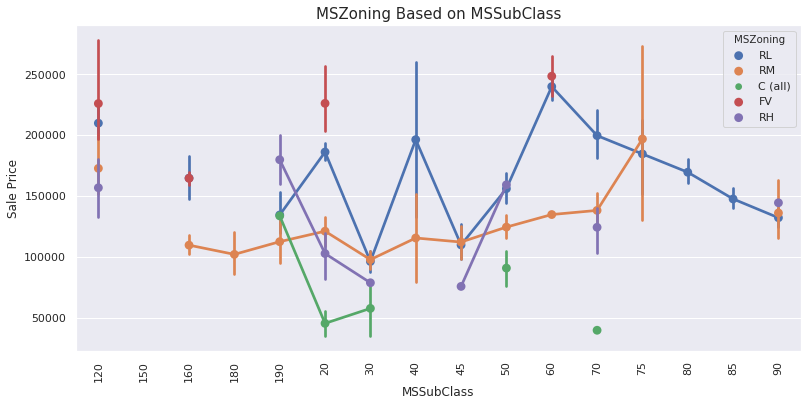

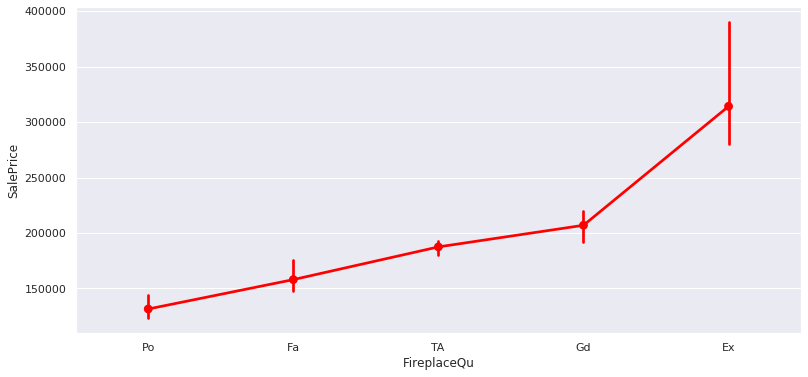

In [45]:
#FactorPlot - Lotshape Based on Neighborhood vs. SalePrice
plt.figure(figsize=(13,6))
g1 = sns.pointplot(x='Neighborhood', y='SalePrice', 
                   data=tmp_fts, hue='LotShape')
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)
g1.set_title("Lotshape Based on Neighborhood", fontsize=15)
g1.set_xlabel("Neighborhood")
g1.set_ylabel("Sale Price", fontsize=12)
plt.show()

#FactorPlot - MSZoning Based on MSSubClass vs. SalePrice
plt.figure(figsize=(13,6))
g1 = sns.pointplot(x='MSSubClass', y='SalePrice', 
                   data=tmp_fts, hue='MSZoning')
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)
g1.set_title("MSZoning Based on MSSubClass", fontsize=15)
g1.set_xlabel("MSSubClass")
g1.set_ylabel("Sale Price", fontsize=12)
plt.show()

#FactorPlot - FirePlaceQC vs. SalePrice
f, axe = plt.subplots(1, 1,figsize=(13,6))
sns.factorplot('FireplaceQu', 'SalePrice', data = tmp_fts, color = 'red', \
               estimator = np.median, order = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], size = 5,  aspect=1.35, ax=axe);
plt.close()                                       

#### Create threshold for dropping columns missing more than 50% data 

- Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [46]:
# Create list of columns to drop where more than 50% of the data was found missing
to_drp = list(missing_data1[missing_data1[' % of Total Observations'] > 0.5].index)
to_drp

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [47]:
# the data description states that NA refers to ('Typ') values
all_features['Functional'] = all_features['Functional'].fillna('Typ')
all_features['Electrical'] = all_features['Electrical'].fillna("SBrkr")
all_features['KitchenQual'] = all_features['KitchenQual'].fillna("TA")

# Group the by MSSubClass and fill in missing value with the mode MSSubClass
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Replace the missing values in each of the columns below with their mode
all_features['Exterior1st'] = all_features['Exterior1st'].fillna(all_features['Exterior1st'].mode()[0])
all_features['Exterior2nd'] = all_features['Exterior2nd'].fillna(all_features['Exterior2nd'].mode()[0])
all_features['SaleType'] = all_features['SaleType'].fillna(all_features['SaleType'].mode()[0])

In [48]:
# drop most frequent missing values 
all_features = all_features.drop(to_drp, axis=1)

#### Impute missing values 

In [49]:
# Impute all categorical features in all_features set containing NaN values with None 
for column_name in all_features.columns:
    if all_features[column_name].dtypes == 'object':
        all_features[column_name] = all_features[column_name].fillna('None')
        unique_category = len(all_features[column_name].unique())
        print(f"Feature '{column_name}' has '{unique_category}' unique categories")

Feature 'MSSubClass' has '16' unique categories
Feature 'MSZoning' has '5' unique categories
Feature 'Street' has '2' unique categories
Feature 'LotShape' has '4' unique categories
Feature 'LandContour' has '4' unique categories
Feature 'Utilities' has '3' unique categories
Feature 'LotConfig' has '5' unique categories
Feature 'LandSlope' has '3' unique categories
Feature 'Neighborhood' has '25' unique categories
Feature 'Condition1' has '9' unique categories
Feature 'Condition2' has '8' unique categories
Feature 'BldgType' has '5' unique categories
Feature 'HouseStyle' has '8' unique categories
Feature 'RoofStyle' has '6' unique categories
Feature 'RoofMatl' has '7' unique categories
Feature 'Exterior1st' has '15' unique categories
Feature 'Exterior2nd' has '16' unique categories
Feature 'MasVnrType' has '4' unique categories
Feature 'ExterQual' has '4' unique categories
Feature 'ExterCond' has '5' unique categories
Feature 'Foundation' has '6' unique categories
Feature 'BsmtQual' has

In [50]:
# Impute all numerical features in all_features set containing NaN values with 0
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for column_name in all_features.columns:
    if all_features[column_name].dtypes in numeric_dtypes:
        all_features[column_name] = all_features[column_name].fillna(0)
        print(f"Features in test set '{column_name}' has '{all_features[column_name].isna().sum()}' null values")

Features in test set 'LotFrontage' has '0' null values
Features in test set 'LotArea' has '0' null values
Features in test set 'OverallQual' has '0' null values
Features in test set 'OverallCond' has '0' null values
Features in test set 'YearBuilt' has '0' null values
Features in test set 'YearRemodAdd' has '0' null values
Features in test set 'MasVnrArea' has '0' null values
Features in test set 'BsmtFinSF1' has '0' null values
Features in test set 'BsmtFinSF2' has '0' null values
Features in test set 'BsmtUnfSF' has '0' null values
Features in test set 'TotalBsmtSF' has '0' null values
Features in test set '1stFlrSF' has '0' null values
Features in test set '2ndFlrSF' has '0' null values
Features in test set 'LowQualFinSF' has '0' null values
Features in test set 'GrLivArea' has '0' null values
Features in test set 'BsmtFullBath' has '0' null values
Features in test set 'BsmtHalfBath' has '0' null values
Features in test set 'FullBath' has '0' null values
Features in test set 'HalfBa

In [51]:
# Disply NaNs in original data 
print(f'Train set has {train.isna().sum().sort_values(ascending=False).head(35)} NaN values')
print()
print(f'Test set has {test.isna().sum().sort_values(ascending=False).head(35)} NaN values')

Train set has PoolQC          1451
MiscFeature     1403
Alley           1366
Fence           1176
FireplaceQu      690
LotFrontage      258
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
Exterior1st        0
RoofStyle          0
ExterQual          0
Exterior2nd        0
YearBuilt          0
ExterCond          0
Foundation         0
YearRemodAdd       0
SalePrice          0
OverallCond        0
OverallQual        0
HouseStyle         0
BldgType           0
Condition2         0
Condition1         0
dtype: int64 NaN values

Test set has PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageFinish      78
GarageYrBlt       78
GarageQual        78
Gar

In [52]:
# Check that there is no more NaN values on imputed data 
print(all_features.isna().sum().sort_values(ascending=False).head(35))

SaleCondition    0
YearRemodAdd     0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
RoofStyle        0
YearBuilt        0
TotalBsmtSF      0
OverallCond      0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
dtype: int64


#### Create new features

In [53]:
all_features['YrBltAndRemod']=all_features['YearBuilt']+all_features['YearRemodAdd']

all_features['TotalSF']=all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])

all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))

all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

# simplified features
all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#### Create threshold for numeric_features skewed > 0.5

In [54]:
# Find skewed numerical features
skw0 = numeric_features.skew().sort_values(ascending=False)

# Find data skewed > 0.5
high_skew = skw0[skw0 > 0.5]

skew_index = high_skew.index

print(f"There are {high_skew.shape[0]} out of {skw0.shape[0]} numerical features with Skew > 0.5")
skewness = pd.DataFrame({'Skew' :high_skew})
skw0.head(30)

There are 25 out of 33 numerical features with Skew > 0.5


MiscVal          21.947201
PoolArea         17.694707
LotArea          13.269377
LowQualFinSF     12.088646
3SsnPorch        11.375940
KitchenAbvGr      4.301911
BsmtFinSF2        4.144996
EnclosedPorch     4.003630
ScreenPorch       3.946335
BsmtHalfBath      3.929621
MasVnrArea        2.610173
OpenPorchSF       2.533111
WoodDeckSF        1.847119
1stFlrSF          1.259407
LotFrontage       1.122014
GrLivArea         1.069506
BsmtFinSF1        0.982147
BsmtUnfSF         0.919646
2ndFlrSF          0.861482
TotRmsAbvGrd      0.749234
Fireplaces        0.725993
HalfBath          0.696480
TotalBsmtSF       0.677239
BsmtFullBath      0.622594
OverallCond       0.569936
BedroomAbvGr      0.326180
GarageArea        0.219100
OverallQual       0.189464
FullBath          0.164976
GarageCars       -0.217756
dtype: float64

#### Perform boxcox tranformation on numeric_features skewed > 0.5

In [55]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

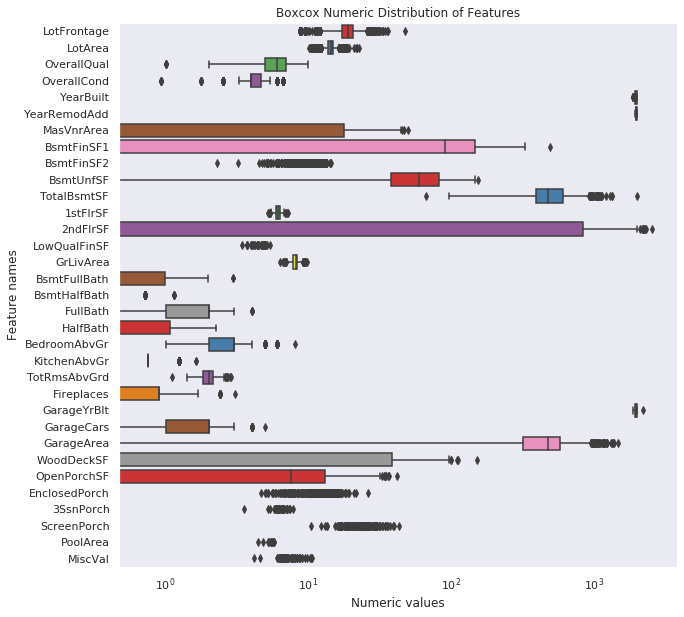

In [56]:
# Create box plots for transformed numeric features
f, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric_features.columns] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Boxcox Numeric Distribution of Features")
plt.show();

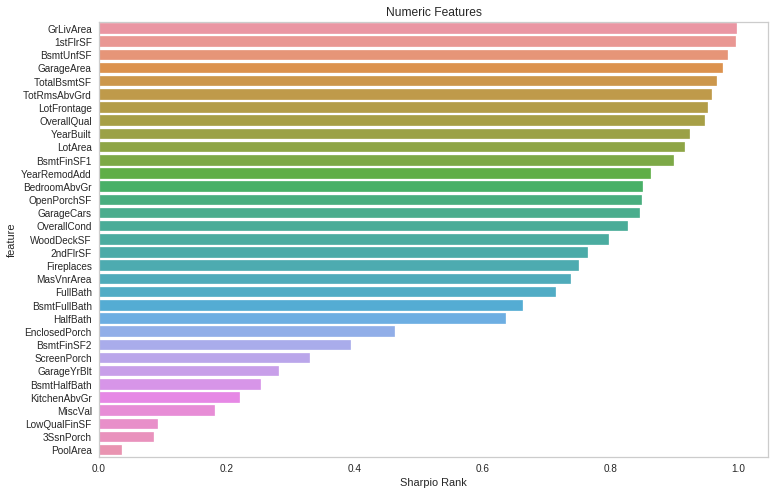

In [57]:
from yellowbrick.features import Rank1D
rnk1 = Rank1D(algorithm='shapiro')
rnk1.fit(all_features[numeric_features.columns], y)           # Fit the data to the visualizer
rnk1.transform(all_features[numeric_features.columns])
plt.close()
rnk1_df = pd.concat([pd.Series(rnk1.ranks_), pd.Series(rnk1.features_)], axis=1)
rnk1_df.columns = ['rank','feature']
rnk1_df = rnk1_df.sort_values(by='rank', ascending=False)
rnk1_df.index = rnk1_df.feature

f, axes = plt.subplots(1,1 ,figsize=(12,8))
sns.barplot(x='rank', y='feature', data=rnk1_df, ax=axes)
plt.title('Numeric Features')
plt.xlabel('Sharpio Rank')
plt.grid(False)
plt.show();

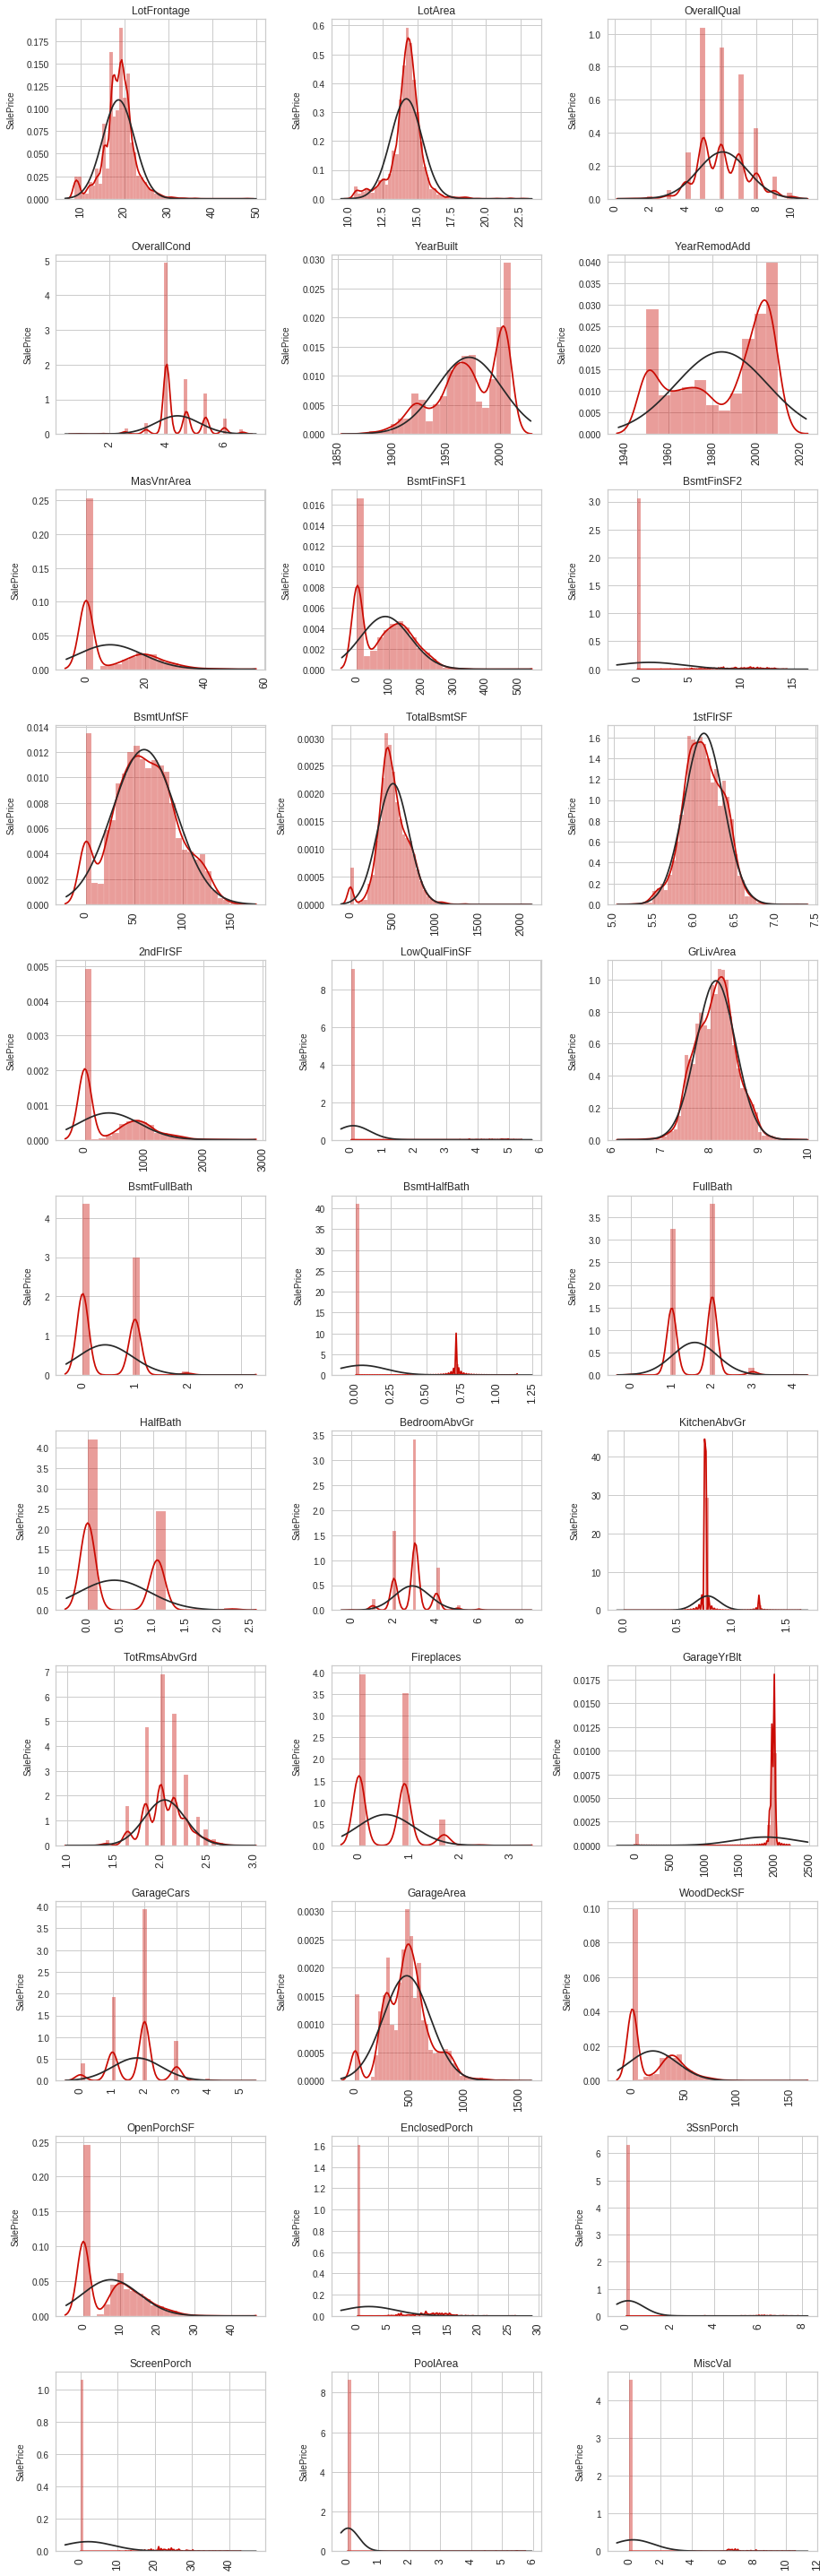

In [58]:
# vizualising numerical features time series vs target 
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(13, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(list(all_features[numeric_features.columns]), 1):
    if(feature=='SalePrice'):
        break
    plt.subplot(len(list(all_features[numeric_features.columns].columns)), 3, i)
    sns.distplot(all_features[feature], fit=stats.norm, color='r')
        
    plt.title(f'{feature}', size=15, fontsize=12)
    plt.ylabel('SalePrice', size=15, labelpad=12.5,fontsize=10)
    plt.xlabel('')
    plt.xticks(rotation=90,fontsize=12)
    
plt.tight_layout()
plt.show()

#### Encode categorical features

In [60]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

In [61]:
# Create a boolean mask for categorical columns
categorical_mask = (all_features.dtypes == object)

# Get list of categorical column names
categorical_columns = all_features.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(all_features[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
all_features[categorical_columns] = all_features[categorical_columns].apply(lambda x: le.fit_transform(x))

print('')
# Print the head of the LabelEncoded categorical columns
print(all_features[categorical_columns].head())

  MSSubClass MSZoning Street LotShape LandContour Utilities LotConfig  \
0         60       RL   Pave      Reg         Lvl    AllPub    Inside   
1         20       RL   Pave      Reg         Lvl    AllPub       FR2   
2         60       RL   Pave      IR1         Lvl    AllPub    Inside   
3         70       RL   Pave      IR1         Lvl    AllPub    Corner   
4         60       RL   Pave      IR1         Lvl    AllPub       FR2   

  LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle  \
0       Gtl      CollgCr       Norm       Norm     1Fam     2Story     Gable   
1       Gtl      Veenker      Feedr       Norm     1Fam     1Story     Gable   
2       Gtl      CollgCr       Norm       Norm     1Fam     2Story     Gable   
3       Gtl      Crawfor       Norm       Norm     1Fam     2Story     Gable   
4       Gtl      NoRidge       Norm       Norm     1Fam     2Story     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation  \


In [62]:
one_hot_frame = pd.get_dummies(all_features,
                            columns=categorical_columns)

print('original df', all_features.shape)
print()
print('onehot df',one_hot_frame.shape)

original df (2916, 85)

onehot df (2916, 325)


In [63]:
one_hot_frame.head()

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0    18.133318  14.054263            7     3.990332       2003          2003   
1    20.660028  14.347269            6     5.997763       1976          1976   
2    18.656316  14.716277            7     3.990332       2001          2002   
3    17.239197  14.335210            7     3.990332       1915          1970   
4    21.300075  15.277957            8     3.990332       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0   19.438231  143.920047         0.0  30.010267   422.114947  5.929136   
1    0.000000  181.454701         0.0  44.168168   593.327333  6.224032   
2   17.773262  110.299851         0.0  56.942688   449.676734  5.984244   
3    0.000000   61.728759         0.0  64.863764   378.526862  6.017495   
4   25.411668  136.439665         0.0  61.217218   544.803190  6.150533   

      2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  1026.391549           0.0   8.339939      0.993263      0.000000         2   
1     0.000000           0.0   7.962253      0.000000      0.710938         2   
2  1041.273148           0.0   8.394288      0.993263      0.000000         2   
3   905.115976           0.0   8.345041      0.993263      0.000000         1   
4  1273.975831           0.0   8.654709      0.993263      0.000000         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0  1.068921             3      0.750955      2.262646    0.000000   
1  0.000000             3      0.750955      1.997107    0.903299   
2  1.068921             3      0.750955      1.997107    0.903299   
3  0.000000             3      0.750955      2.137976    0.903299   
4  1.068921             4      0.750955      2.374499    0.903299   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0       2003.0         2.0       548.0    0.000000    12.071122   
1       1976.0         2.0       460.0   56.101584     0.000000   
2       2001.0         2.0       608.0    0.000000     9.894344   
3       1998.0         3.0       642.0    0.000000     8.960357   
4       2000.0         3.0       836.0   42.189389    14.259706   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  YrBltAndRemod  \
0       0.000000        0.0          0.0       0.0      0.0           4006   
1       0.000000        0.0          0.0       0.0      0.0           3952   
2       0.000000        0.0          0.0       0.0      0.0           4003   
3      16.025062        0.0          0.0       0.0      0.0           3885   
4       0.000000        0.0          0.0       0.0      0.0           4000   

   TotalSF  Total_sqr_footage  Total_Bathrooms  Total_porch_sf  haspool  \
0   2566.0             2416.0              3.5              61        0   
1   2524.0             2240.0              2.5             298        0   
2   2706.0             2272.0              3.5              42        0   
3   2473.0             1933.0              2.0             307        0   
4   3343.0             2853.0              3.5             276        0   

   has2ndfloor  hasgarage  hasbsmt  hasfireplace  MSSubClass_0  MSSubClass_1  \
0            1          1        1             0             0             0   
1            0          1        1             1             0             0   
2            1          1        1             1             0             0   
3            1          1        1             1             0             0   
4            1          1        1             1             0             0   

   MSSubClass_2  MSSubClass_3  MSSubClass_4  MSSubClass_5  MSSubClass_6  \
0             0             0             0             0             0   
1             0             0             0             1             0   
2             0             0             0             0             0   
3             0             0             0             0        

In [64]:
# Remove any duplicated column names
one_hot_frame = one_hot_frame.loc[:,~one_hot_frame.columns.duplicated()]

print('onehot df',one_hot_frame.shape)

onehot df (2916, 325)


#### Recreate training and test sets

In [65]:
X_train = one_hot_frame.iloc[:len(train_target), :]
X_test = one_hot_frame.iloc[len(train_target):, :]
train_target = pd.DataFrame(train_target)

X_train.shape, train_target.shape, X_test.shape

((1457, 325), (1457, 1), (1459, 325))

In [66]:
# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
print(overfit)

['MSSubClass_1', 'Utilities_2']


In [67]:
# Save to csv file for furth analysis and ML Pipline 
X_train.to_csv('HP_fts_X_train.csv')
X_test.to_csv('HP_fts_X_test.csv')
train_target.to_csv('y_train.csv')